## 1. Import packages

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import os
from torch import nn
from tqdm import tqdm

## 2. Load Data

In [21]:
data = pd.read_csv("AI_Lec_23_final_stocks.csv", header=None)

stock_dict = defaultdict(list)

for dat in data[0]:
    dat = dat.split("\t")
    for i in range(len(dat)):
        stock_dict[i].append(float(dat[i]))

for i in range(len(stock_dict)):
    stock_dict[i] = np.array(stock_dict[i])


## 3. Make RNN Dataset

In [81]:
def Make_RNN_Dataset(stock_num, input_sequence = 50, predict_sequence = 20):
    stock_data = stock_dict[stock_num]
    scalar = MinMaxScaler()
    stock_data = scalar.fit_transform(stock_data.reshape(-1, 1))[:, 0]

    X = []
    y = []

    for i in range(len(stock_data) - input_sequence - predict_sequence):
        X.append(stock_data[i:(i+input_sequence)])
        y.append(stock_data[(i+input_sequence):(i+input_sequence+predict_sequence)])
        
    X = np.expand_dims(np.vstack(X), axis = 2)
    return scalar, X, np.vstack(y)


In [82]:
scalar, X, y = Make_RNN_Dataset(stock_num=0, input_sequence=50, predict_sequence=20)

In [85]:
batch_size = 16


X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
train = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)

## 4. Make RNN Model

In [119]:
input_size = X.size(2)
num_layers = 2
hidden_size = 8
sequence_length = 50

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

result_path = "./Experiment"
os.makedirs(result_path, exist_ok = True)

cuda:0 is available


In [128]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 20))

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) 
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out


model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [129]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

## 5. Train

In [130]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)
best_loss = 1000000

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data
    seq = seq.to(device)
    target = target.to(device)
    out = model(seq)  
    loss = criterion(out, target) 

    optimizer.zero_grad() #
    loss.backward() 
    optimizer.step() 
    # scheduler.step()
    running_loss += loss.item() 

  loss_graph.append(running_loss / n) 
  if epoch % 10 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))
    if (running_loss / n) < best_loss:
      print(f'Loss Decreased({best_loss:.6f}--->{(running_loss / n):.6f}) \t Saving The Model')
      best_loss = (running_loss / n)
      torch.save(model.state_dict(), os.path.join(result_path, 'Best_rnn_model_2layers.pth'))
  

[epoch: 0] loss: 0.0021
Loss Decreased(1000000.000000--->0.002101) 	 Saving The Model
[epoch: 10] loss: 0.0116
[epoch: 20] loss: 0.0007
Loss Decreased(0.002101--->0.000667) 	 Saving The Model
[epoch: 30] loss: 0.0008
[epoch: 40] loss: 0.0007
[epoch: 50] loss: 0.0006
Loss Decreased(0.000667--->0.000647) 	 Saving The Model
[epoch: 60] loss: 0.0006
Loss Decreased(0.000647--->0.000593) 	 Saving The Model
[epoch: 70] loss: 0.0006
Loss Decreased(0.000593--->0.000553) 	 Saving The Model
[epoch: 80] loss: 0.0005
Loss Decreased(0.000553--->0.000522) 	 Saving The Model
[epoch: 90] loss: 0.0005
Loss Decreased(0.000522--->0.000501) 	 Saving The Model
[epoch: 100] loss: 0.0005
Loss Decreased(0.000501--->0.000483) 	 Saving The Model
[epoch: 110] loss: 0.0005
Loss Decreased(0.000483--->0.000471) 	 Saving The Model
[epoch: 120] loss: 0.0005
Loss Decreased(0.000471--->0.000458) 	 Saving The Model
[epoch: 130] loss: 0.0005
Loss Decreased(0.000458--->0.000450) 	 Saving The Model
[epoch: 140] loss: 0.0004

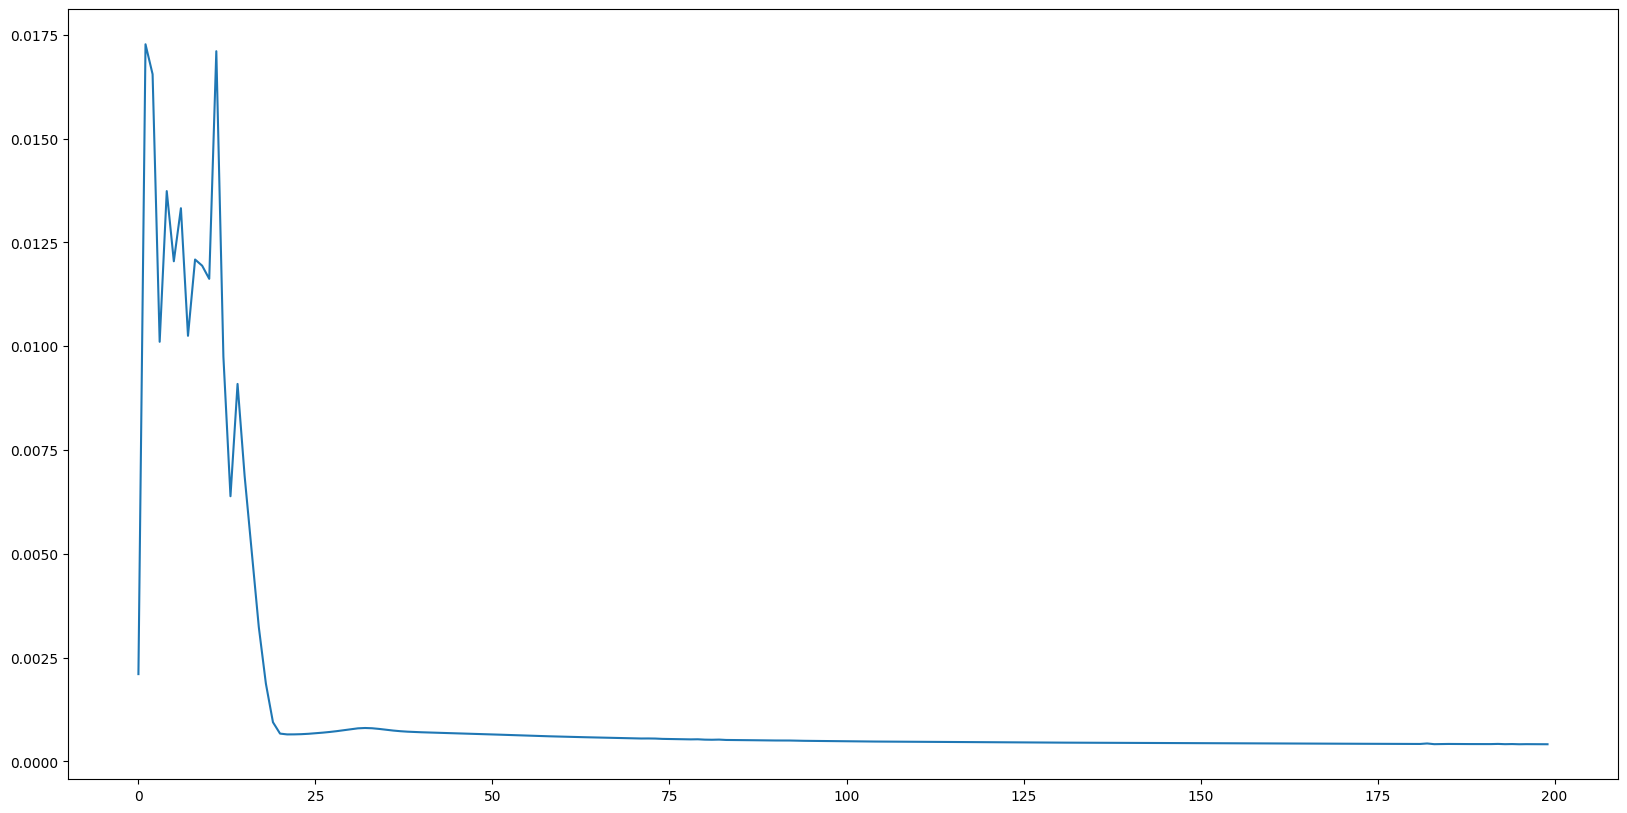

In [131]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 6. Performance

In [150]:
model.load_state_dict(torch.load("Experiment/Best_rnn_model_2layers.pth"))

with torch.no_grad():
    train_pred = []
    train_true = []
    for data in train_loader:
      seq, target = data # 배치 데이터.
      seq = seq.to(device)
      out = model(seq)
      train_pred += out[:, 0].cpu().numpy().tolist()
      train_true += target[:, 0].cpu().numpy().tolist()
    train_pred += out[-1, 1:].cpu().numpy().tolist()
    train_true += target[-1, 1:].cpu().numpy().tolist()

train_pred = np.array(train_pred)
train_true = np.array(train_true)

In [156]:
print("정규화 후 MSE: {}".format(mean_squared_error(train_pred, train_true)))

train_pred_restored = scalar.inverse_transform(train_pred.reshape(-1,1))[:, 0]
train_true_restored = scalar.inverse_transform(train_true.reshape(-1,1))[:, 0]

print("역정규화 후 MSE: {}".format(mean_squared_error(train_pred_restored, train_true_restored)))

정규화 후 MSE: 0.0007453994311901895
역정규화 후 MSE: 9.133704129033969


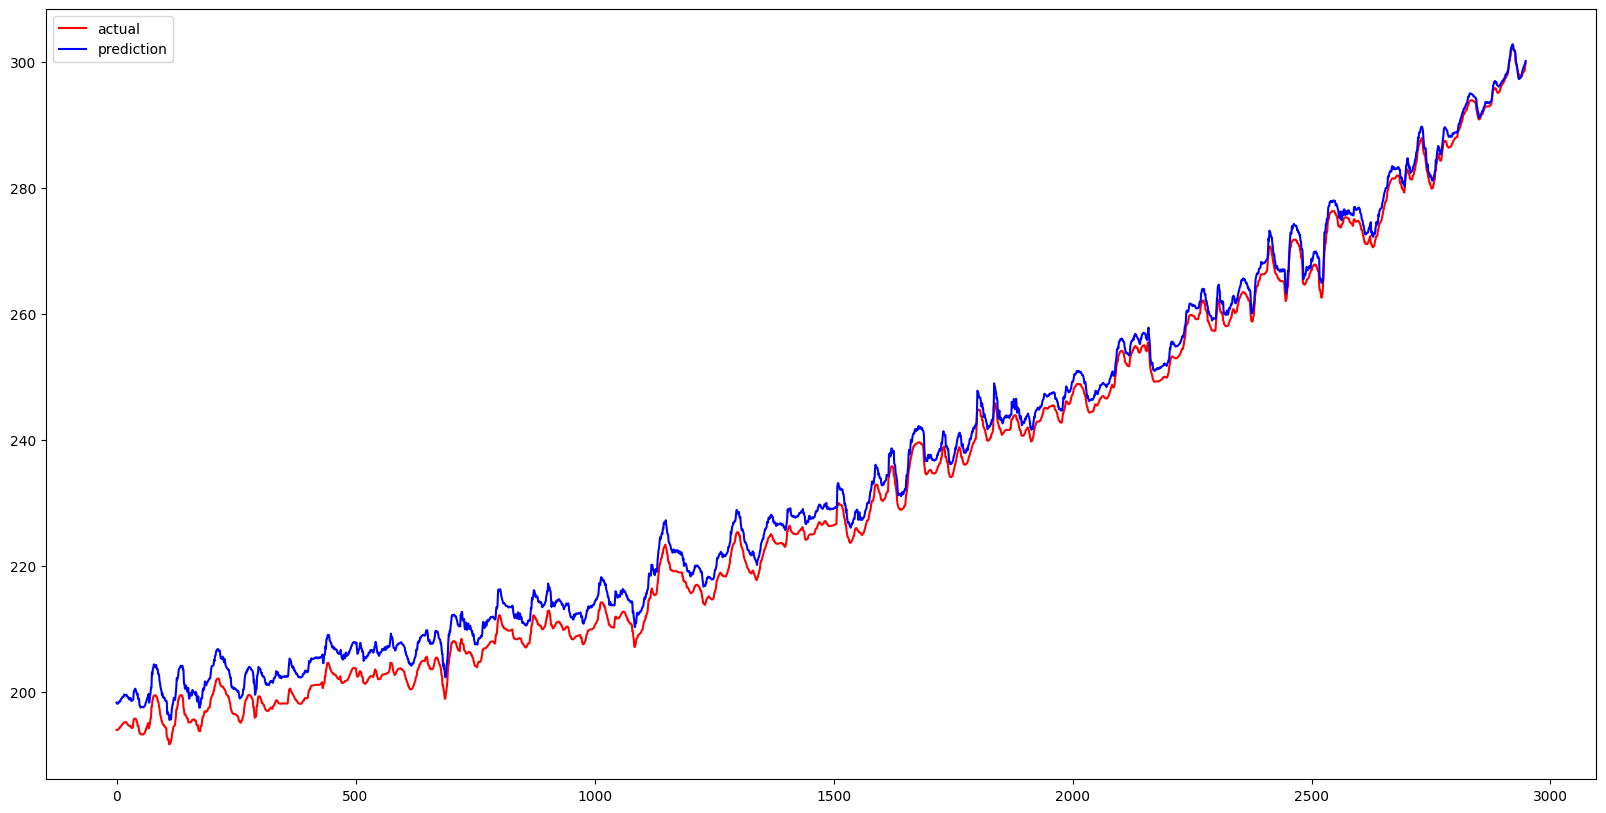

In [157]:
plt.figure(figsize=(20,10))
plt.plot(train_true_restored, 'r')
plt.plot(train_pred_restored, 'b')

plt.legend(['actual', 'prediction'])
plt.show()

## 7. 전체 결과물 저장

In [168]:
def Make_Test_Dataset(stock_num, input_sequence = 50, predict_sequence = 20):
    stock_data = stock_dict[stock_num]
    scalar = MinMaxScaler()
    stock_data = scalar.fit_transform(stock_data.reshape(-1, 1))[:, 0]

    X = stock_data[-input_sequence:].reshape(1, input_sequence, 1)
    return X


In [175]:
outputs = []

for index in range(100):
  scalar, X, y = Make_RNN_Dataset(stock_num=index, input_sequence=50, predict_sequence=20)
  test_X = Make_Test_Dataset(stock_num=index, input_sequence=50, predict_sequence=20)

  batch_size = 64
  X = torch.FloatTensor(X)
  y = torch.FloatTensor(y)
  train = torch.utils.data.TensorDataset(X, y)
  train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)

  model = VanillaRNN(input_size=input_size,
                    hidden_size=hidden_size,
                    sequence_length=sequence_length,
                    num_layers=num_layers,
                    device=device).to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

  loss_graph = [] # 그래프 그릴 목적인 loss.
  n = len(train_loader)
  best_loss = 1000000

  for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    for data in train_loader:

      seq, target = data
      seq = seq.to(device)
      target = target.to(device)
      out = model(seq)  
      loss = criterion(out, target) 

      optimizer.zero_grad() #
      loss.backward() 
      optimizer.step() 
      # scheduler.step()
      running_loss += loss.item() 

    loss_graph.append(running_loss / n) 
    if epoch % 10 == 0:
      print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))
      if (running_loss / n) < best_loss:
        print(f'Loss Decreased({best_loss:.6f}--->{(running_loss / n):.6f}) \t Saving The Model')
        best_loss = (running_loss / n)
        torch.save(model.state_dict(), os.path.join(result_path, 'Best_rnn_model_2layers.pth'))
    

  model.load_state_dict(torch.load("Experiment/Best_rnn_model_2layers.pth"))


  with torch.no_grad():
      test_X = torch.FloatTensor(test_X)
      test_X = test_X.to(device)
      out = model(test_X)
      out = out.cpu().numpy()[0]

  out = scalar.inverse_transform(out.reshape(-1,1))[:, 0]

  outputs.append(out)


  0%|          | 1/200 [00:00<00:50,  3.96it/s]

[epoch: 0] loss: 0.0026
Loss Decreased(1000000.000000--->0.002642) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0007
Loss Decreased(0.002642--->0.000738) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0008


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0008


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0007
Loss Decreased(0.000738--->0.000668) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.67it/s]

[epoch: 50] loss: 0.0007
Loss Decreased(0.000668--->0.000657) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0008


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0008


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0010


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0011


 50%|█████     | 101/200 [00:27<00:26,  3.68it/s]

[epoch: 100] loss: 0.0005
Loss Decreased(0.000657--->0.000501) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.79it/s]

[epoch: 110] loss: 0.0006


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0268


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0017


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0012


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0006


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0014


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0011


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0013


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0011


  0%|          | 1/200 [00:00<00:51,  3.89it/s]

[epoch: 0] loss: 0.0077
Loss Decreased(1000000.000000--->0.007705) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:48,  3.87it/s]

[epoch: 10] loss: 0.0100


 10%|█         | 21/200 [00:05<00:46,  3.87it/s]

[epoch: 20] loss: 0.0040
Loss Decreased(0.007705--->0.004030) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:43,  3.89it/s]

[epoch: 30] loss: 0.0072


 20%|██        | 41/200 [00:10<00:40,  3.89it/s]

[epoch: 40] loss: 0.0056


 26%|██▌       | 51/200 [00:13<00:39,  3.77it/s]

[epoch: 50] loss: 0.0050


 30%|███       | 61/200 [00:15<00:37,  3.74it/s]

[epoch: 60] loss: 0.0044


 36%|███▌      | 71/200 [00:18<00:34,  3.70it/s]

[epoch: 70] loss: 0.0037
Loss Decreased(0.004030--->0.003660) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0028
Loss Decreased(0.003660--->0.002823) 	 Saving The Model


 46%|████▌     | 91/200 [00:23<00:28,  3.78it/s]

[epoch: 90] loss: 0.0028


 50%|█████     | 101/200 [00:26<00:26,  3.76it/s]

[epoch: 100] loss: 0.0025
Loss Decreased(0.002823--->0.002522) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.79it/s]

[epoch: 110] loss: 0.0025


 60%|██████    | 121/200 [00:31<00:20,  3.78it/s]

[epoch: 120] loss: 0.0030


 66%|██████▌   | 131/200 [00:34<00:18,  3.74it/s]

[epoch: 130] loss: 0.0023
Loss Decreased(0.002522--->0.002347) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0023
Loss Decreased(0.002347--->0.002335) 	 Saving The Model


 76%|███████▌  | 151/200 [00:39<00:13,  3.74it/s]

[epoch: 150] loss: 0.0024


 80%|████████  | 161/200 [00:42<00:10,  3.72it/s]

[epoch: 160] loss: 0.0022
Loss Decreased(0.002335--->0.002158) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.73it/s]

[epoch: 170] loss: 0.0022


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0021
Loss Decreased(0.002158--->0.002129) 	 Saving The Model


 96%|█████████▌| 191/200 [00:50<00:02,  3.72it/s]

[epoch: 190] loss: 0.0020
Loss Decreased(0.002129--->0.002016) 	 Saving The Model


  0%|          | 1/200 [00:00<00:53,  3.69it/s]

[epoch: 0] loss: 0.0196
Loss Decreased(1000000.000000--->0.019569) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0567


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0191
Loss Decreased(0.019569--->0.019098) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0129
Loss Decreased(0.019098--->0.012928) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0103
Loss Decreased(0.012928--->0.010297) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0082
Loss Decreased(0.010297--->0.008247) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0068
Loss Decreased(0.008247--->0.006767) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0062
Loss Decreased(0.006767--->0.006193) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0061
Loss Decreased(0.006193--->0.006114) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0062


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0063


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0077


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0063


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0097


 70%|███████   | 141/200 [00:37<00:15,  3.69it/s]

[epoch: 140] loss: 0.0075


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0081


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0114


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0071


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0116


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0064


  0%|          | 1/200 [00:00<00:56,  3.51it/s]

[epoch: 0] loss: 0.0155
Loss Decreased(1000000.000000--->0.015510) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0123
Loss Decreased(0.015510--->0.012348) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0100
Loss Decreased(0.012348--->0.010044) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0088
Loss Decreased(0.010044--->0.008759) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0072
Loss Decreased(0.008759--->0.007186) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0060
Loss Decreased(0.007186--->0.005999) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.74it/s]

[epoch: 60] loss: 0.0057
Loss Decreased(0.005999--->0.005732) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0056
Loss Decreased(0.005732--->0.005575) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.72it/s]

[epoch: 80] loss: 0.0053
Loss Decreased(0.005575--->0.005325) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0051
Loss Decreased(0.005325--->0.005096) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.67it/s]

[epoch: 100] loss: 0.0049
Loss Decreased(0.005096--->0.004944) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.80it/s]

[epoch: 110] loss: 0.0049
Loss Decreased(0.004944--->0.004895) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:20,  3.82it/s]

[epoch: 120] loss: 0.0053


 66%|██████▌   | 131/200 [00:35<00:18,  3.78it/s]

[epoch: 130] loss: 0.0051


 70%|███████   | 141/200 [00:37<00:15,  3.69it/s]

[epoch: 140] loss: 0.0054


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0059


 80%|████████  | 161/200 [00:43<00:10,  3.79it/s]

[epoch: 160] loss: 0.0056


 86%|████████▌ | 171/200 [00:45<00:07,  3.81it/s]

[epoch: 170] loss: 0.0056


 90%|█████████ | 181/200 [00:48<00:04,  3.81it/s]

[epoch: 180] loss: 0.0057


 96%|█████████▌| 191/200 [00:51<00:02,  3.68it/s]

[epoch: 190] loss: 0.0056


  0%|          | 1/200 [00:00<00:50,  3.96it/s]

[epoch: 0] loss: 0.0076
Loss Decreased(1000000.000000--->0.007611) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.78it/s]

[epoch: 10] loss: 0.0032
Loss Decreased(0.007611--->0.003200) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0028
Loss Decreased(0.003200--->0.002798) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0027
Loss Decreased(0.002798--->0.002687) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0026
Loss Decreased(0.002687--->0.002643) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0026
Loss Decreased(0.002643--->0.002582) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0025
Loss Decreased(0.002582--->0.002537) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:35,  3.66it/s]

[epoch: 70] loss: 0.0025
Loss Decreased(0.002537--->0.002499) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.66it/s]

[epoch: 80] loss: 0.0025
Loss Decreased(0.002499--->0.002460) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.68it/s]

[epoch: 90] loss: 0.0024
Loss Decreased(0.002460--->0.002436) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0038


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0025


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0025


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0023
Loss Decreased(0.002436--->0.002281) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0022
Loss Decreased(0.002281--->0.002237) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.75it/s]

[epoch: 150] loss: 0.0023


 80%|████████  | 161/200 [00:43<00:10,  3.74it/s]

[epoch: 160] loss: 0.0023


 86%|████████▌ | 171/200 [00:45<00:07,  3.73it/s]

[epoch: 170] loss: 0.0021
Loss Decreased(0.002237--->0.002144) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0021
Loss Decreased(0.002144--->0.002107) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.74it/s]

[epoch: 190] loss: 0.0020
Loss Decreased(0.002107--->0.001976) 	 Saving The Model


  0%|          | 1/200 [00:00<00:57,  3.44it/s]

[epoch: 0] loss: 0.0844
Loss Decreased(1000000.000000--->0.084406) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.1283


 10%|█         | 21/200 [00:05<00:48,  3.68it/s]

[epoch: 20] loss: 0.0602
Loss Decreased(0.084406--->0.060222) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0088
Loss Decreased(0.060222--->0.008810) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.68it/s]

[epoch: 40] loss: 0.0067
Loss Decreased(0.008810--->0.006668) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.69it/s]

[epoch: 50] loss: 0.0056
Loss Decreased(0.006668--->0.005646) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.68it/s]

[epoch: 60] loss: 0.0049
Loss Decreased(0.005646--->0.004918) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0048
Loss Decreased(0.004918--->0.004784) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.67it/s]

[epoch: 80] loss: 0.0051


 46%|████▌     | 91/200 [00:24<00:29,  3.67it/s]

[epoch: 90] loss: 0.0052


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0053


 56%|█████▌    | 111/200 [00:30<00:23,  3.75it/s]

[epoch: 110] loss: 0.0050


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0031
Loss Decreased(0.004784--->0.003115) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0035


 70%|███████   | 141/200 [00:38<00:15,  3.70it/s]

[epoch: 140] loss: 0.0035


 76%|███████▌  | 151/200 [00:40<00:13,  3.76it/s]

[epoch: 150] loss: 0.0040


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0033


 86%|████████▌ | 171/200 [00:46<00:07,  3.66it/s]

[epoch: 170] loss: 0.0027
Loss Decreased(0.003115--->0.002681) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.69it/s]

[epoch: 180] loss: 0.0049


 96%|█████████▌| 191/200 [00:51<00:02,  3.74it/s]

[epoch: 190] loss: 0.0035


  0%|          | 1/200 [00:00<00:52,  3.76it/s]

[epoch: 0] loss: 0.0052
Loss Decreased(1000000.000000--->0.005243) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.75it/s]

[epoch: 10] loss: 0.0038
Loss Decreased(0.005243--->0.003789) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0023
Loss Decreased(0.003789--->0.002292) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0017
Loss Decreased(0.002292--->0.001735) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.74it/s]

[epoch: 40] loss: 0.0023


 26%|██▌       | 51/200 [00:13<00:39,  3.76it/s]

[epoch: 50] loss: 0.0019


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0015
Loss Decreased(0.001735--->0.001533) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.74it/s]

[epoch: 70] loss: 0.0013
Loss Decreased(0.001533--->0.001334) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.75it/s]

[epoch: 80] loss: 0.0014


 46%|████▌     | 91/200 [00:24<00:28,  3.76it/s]

[epoch: 90] loss: 0.0013


 50%|█████     | 101/200 [00:26<00:26,  3.76it/s]

[epoch: 100] loss: 0.0016


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0014


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0014


 66%|██████▌   | 131/200 [00:34<00:18,  3.75it/s]

[epoch: 130] loss: 0.0014


 70%|███████   | 141/200 [00:37<00:15,  3.75it/s]

[epoch: 140] loss: 0.0014


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0014


 80%|████████  | 161/200 [00:42<00:10,  3.72it/s]

[epoch: 160] loss: 0.0014


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0013
Loss Decreased(0.001334--->0.001250) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0013


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0012
Loss Decreased(0.001250--->0.001215) 	 Saving The Model


  0%|          | 1/200 [00:00<00:54,  3.68it/s]

[epoch: 0] loss: 0.0198
Loss Decreased(1000000.000000--->0.019817) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.75it/s]

[epoch: 10] loss: 0.0655


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0181
Loss Decreased(0.019817--->0.018135) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0143
Loss Decreased(0.018135--->0.014322) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0122
Loss Decreased(0.014322--->0.012241) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0107
Loss Decreased(0.012241--->0.010674) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0099
Loss Decreased(0.010674--->0.009941) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0096
Loss Decreased(0.009941--->0.009628) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.72it/s]

[epoch: 80] loss: 0.0095
Loss Decreased(0.009628--->0.009479) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0093
Loss Decreased(0.009479--->0.009314) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:27,  3.66it/s]

[epoch: 100] loss: 0.0091
Loss Decreased(0.009314--->0.009065) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0082
Loss Decreased(0.009065--->0.008247) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0087


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0088


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0123


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0110


 80%|████████  | 161/200 [00:43<00:10,  3.74it/s]

[epoch: 160] loss: 0.0097


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0101


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0092


 96%|█████████▌| 191/200 [00:51<00:02,  3.75it/s]

[epoch: 190] loss: 0.0085


  0%|          | 1/200 [00:00<00:55,  3.57it/s]

[epoch: 0] loss: 0.0163
Loss Decreased(1000000.000000--->0.016265) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:49,  3.80it/s]

[epoch: 10] loss: 0.0104
Loss Decreased(0.016265--->0.010418) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0080
Loss Decreased(0.010418--->0.008023) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0075
Loss Decreased(0.008023--->0.007502) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0072
Loss Decreased(0.007502--->0.007190) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0070
Loss Decreased(0.007190--->0.006993) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.74it/s]

[epoch: 60] loss: 0.0069
Loss Decreased(0.006993--->0.006881) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.75it/s]

[epoch: 70] loss: 0.0068
Loss Decreased(0.006881--->0.006803) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.72it/s]

[epoch: 80] loss: 0.0067
Loss Decreased(0.006803--->0.006699) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0066
Loss Decreased(0.006699--->0.006638) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.67it/s]

[epoch: 100] loss: 0.0066


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0067


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0069


 66%|██████▌   | 131/200 [00:35<00:18,  3.77it/s]

[epoch: 130] loss: 0.0066
Loss Decreased(0.006638--->0.006604) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.76it/s]

[epoch: 140] loss: 0.0067


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0066


 80%|████████  | 161/200 [00:43<00:10,  3.76it/s]

[epoch: 160] loss: 0.0066


 86%|████████▌ | 171/200 [00:45<00:07,  3.76it/s]

[epoch: 170] loss: 0.0067


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0067


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0064
Loss Decreased(0.006604--->0.006401) 	 Saving The Model


  0%|          | 1/200 [00:00<00:51,  3.83it/s]

[epoch: 0] loss: 0.0064
Loss Decreased(1000000.000000--->0.006385) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.68it/s]

[epoch: 10] loss: 0.0043
Loss Decreased(0.006385--->0.004271) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0024
Loss Decreased(0.004271--->0.002395) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0022
Loss Decreased(0.002395--->0.002189) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.74it/s]

[epoch: 40] loss: 0.0022


 26%|██▌       | 51/200 [00:13<00:39,  3.76it/s]

[epoch: 50] loss: 0.0024


 30%|███       | 61/200 [00:16<00:36,  3.76it/s]

[epoch: 60] loss: 0.0025


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0025


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0051


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0024


 50%|█████     | 101/200 [00:27<00:26,  3.75it/s]

[epoch: 100] loss: 0.0030


 56%|█████▌    | 111/200 [00:29<00:23,  3.76it/s]

[epoch: 110] loss: 0.0027


 60%|██████    | 121/200 [00:32<00:20,  3.77it/s]

[epoch: 120] loss: 0.0026


 66%|██████▌   | 131/200 [00:35<00:18,  3.76it/s]

[epoch: 130] loss: 0.0035


 70%|███████   | 141/200 [00:37<00:15,  3.76it/s]

[epoch: 140] loss: 0.0022
Loss Decreased(0.002189--->0.002158) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.76it/s]

[epoch: 150] loss: 0.0022


 80%|████████  | 161/200 [00:43<00:10,  3.75it/s]

[epoch: 160] loss: 0.0027


 86%|████████▌ | 171/200 [00:45<00:07,  3.76it/s]

[epoch: 170] loss: 0.0030


 90%|█████████ | 181/200 [00:48<00:05,  3.76it/s]

[epoch: 180] loss: 0.0020
Loss Decreased(0.002158--->0.001978) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.76it/s]

[epoch: 190] loss: 0.0020


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0064
Loss Decreased(1000000.000000--->0.006353) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.70it/s]

[epoch: 10] loss: 0.0008
Loss Decreased(0.006353--->0.000811) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0010


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0012


 20%|██        | 41/200 [00:11<00:43,  3.69it/s]

[epoch: 40] loss: 0.0010


 26%|██▌       | 51/200 [00:13<00:40,  3.69it/s]

[epoch: 50] loss: 0.0008


 30%|███       | 61/200 [00:16<00:37,  3.68it/s]

[epoch: 60] loss: 0.0008
Loss Decreased(0.000811--->0.000760) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.69it/s]

[epoch: 70] loss: 0.0009


 40%|████      | 81/200 [00:21<00:32,  3.72it/s]

[epoch: 80] loss: 0.0011


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0011


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0038


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0007
Loss Decreased(0.000760--->0.000716) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0008


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0008


 70%|███████   | 141/200 [00:38<00:15,  3.71it/s]

[epoch: 140] loss: 0.0008


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0008


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0007


 86%|████████▌ | 171/200 [00:46<00:07,  3.67it/s]

[epoch: 170] loss: 0.0006
Loss Decreased(0.000716--->0.000648) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.68it/s]

[epoch: 180] loss: 0.0006
Loss Decreased(0.000648--->0.000643) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.68it/s]

[epoch: 190] loss: 0.0007


  0%|          | 1/200 [00:00<00:56,  3.55it/s]

[epoch: 0] loss: 0.0088
Loss Decreased(1000000.000000--->0.008821) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0018
Loss Decreased(0.008821--->0.001808) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0017
Loss Decreased(0.001808--->0.001692) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0020


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0031


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0029


 30%|███       | 61/200 [00:16<00:36,  3.76it/s]

[epoch: 60] loss: 0.0028


 36%|███▌      | 71/200 [00:19<00:34,  3.74it/s]

[epoch: 70] loss: 0.0026


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0025


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0024


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0022


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0021


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0020


 66%|██████▌   | 131/200 [00:35<00:18,  3.74it/s]

[epoch: 130] loss: 0.0020


 70%|███████   | 141/200 [00:37<00:15,  3.75it/s]

[epoch: 140] loss: 0.0019


 76%|███████▌  | 151/200 [00:40<00:13,  3.66it/s]

[epoch: 150] loss: 0.0017


 80%|████████  | 161/200 [00:43<00:10,  3.73it/s]

[epoch: 160] loss: 0.0016
Loss Decreased(0.001692--->0.001647) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0016
Loss Decreased(0.001647--->0.001558) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0015
Loss Decreased(0.001558--->0.001463) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0014
Loss Decreased(0.001463--->0.001386) 	 Saving The Model


  0%|          | 1/200 [00:00<00:55,  3.58it/s]

[epoch: 0] loss: 0.0033
Loss Decreased(1000000.000000--->0.003331) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0017
Loss Decreased(0.003331--->0.001722) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0028


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0031


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0027


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0024


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0021


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0017
Loss Decreased(0.001722--->0.001666) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0011
Loss Decreased(0.001666--->0.001077) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0010
Loss Decreased(0.001077--->0.000971) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0011


 56%|█████▌    | 111/200 [00:29<00:24,  3.67it/s]

[epoch: 110] loss: 0.0010


 60%|██████    | 121/200 [00:32<00:21,  3.67it/s]

[epoch: 120] loss: 0.0021


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0009
Loss Decreased(0.000971--->0.000941) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.70it/s]

[epoch: 140] loss: 0.0016


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0009
Loss Decreased(0.000941--->0.000861) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.73it/s]

[epoch: 160] loss: 0.0023


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0008
Loss Decreased(0.000861--->0.000783) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0017


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0007
Loss Decreased(0.000783--->0.000722) 	 Saving The Model


  0%|          | 1/200 [00:00<00:52,  3.78it/s]

[epoch: 0] loss: 0.0137
Loss Decreased(1000000.000000--->0.013676) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0115
Loss Decreased(0.013676--->0.011454) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.75it/s]

[epoch: 20] loss: 0.0054
Loss Decreased(0.011454--->0.005354) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0049
Loss Decreased(0.005354--->0.004876) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.74it/s]

[epoch: 40] loss: 0.0045
Loss Decreased(0.004876--->0.004536) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.76it/s]

[epoch: 50] loss: 0.0043
Loss Decreased(0.004536--->0.004282) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:36,  3.76it/s]

[epoch: 60] loss: 0.0041
Loss Decreased(0.004282--->0.004150) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:31,  4.06it/s]

[epoch: 70] loss: 0.0041
Loss Decreased(0.004150--->0.004074) 	 Saving The Model


 40%|████      | 81/200 [00:20<00:24,  4.84it/s]

[epoch: 80] loss: 0.0040
Loss Decreased(0.004074--->0.004008) 	 Saving The Model


 46%|████▌     | 91/200 [00:22<00:22,  4.87it/s]

[epoch: 90] loss: 0.0039
Loss Decreased(0.004008--->0.003942) 	 Saving The Model


 50%|█████     | 101/200 [00:25<00:26,  3.77it/s]

[epoch: 100] loss: 0.0039
Loss Decreased(0.003942--->0.003880) 	 Saving The Model


 56%|█████▌    | 111/200 [00:28<00:23,  3.72it/s]

[epoch: 110] loss: 0.0038
Loss Decreased(0.003880--->0.003824) 	 Saving The Model


 60%|██████    | 121/200 [00:30<00:21,  3.74it/s]

[epoch: 120] loss: 0.0038
Loss Decreased(0.003824--->0.003772) 	 Saving The Model


 66%|██████▌   | 131/200 [00:33<00:18,  3.73it/s]

[epoch: 130] loss: 0.0037
Loss Decreased(0.003772--->0.003719) 	 Saving The Model


 70%|███████   | 141/200 [00:36<00:15,  3.70it/s]

[epoch: 140] loss: 0.0037
Loss Decreased(0.003719--->0.003667) 	 Saving The Model


 76%|███████▌  | 151/200 [00:38<00:13,  3.70it/s]

[epoch: 150] loss: 0.0036
Loss Decreased(0.003667--->0.003619) 	 Saving The Model


 80%|████████  | 161/200 [00:41<00:10,  3.69it/s]

[epoch: 160] loss: 0.0036
Loss Decreased(0.003619--->0.003576) 	 Saving The Model


 86%|████████▌ | 171/200 [00:44<00:07,  3.71it/s]

[epoch: 170] loss: 0.0035
Loss Decreased(0.003576--->0.003544) 	 Saving The Model


 90%|█████████ | 181/200 [00:47<00:05,  3.77it/s]

[epoch: 180] loss: 0.0036


 96%|█████████▌| 191/200 [00:49<00:02,  3.76it/s]

[epoch: 190] loss: 0.0036


  0%|          | 1/200 [00:00<00:55,  3.58it/s]

[epoch: 0] loss: 0.0044
Loss Decreased(1000000.000000--->0.004361) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0009
Loss Decreased(0.004361--->0.000917) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0008
Loss Decreased(0.000917--->0.000814) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0009


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0007
Loss Decreased(0.000814--->0.000680) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.76it/s]

[epoch: 50] loss: 0.0005
Loss Decreased(0.000680--->0.000482) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0005


 36%|███▌      | 71/200 [00:18<00:34,  3.73it/s]

[epoch: 70] loss: 0.0007


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0008


 46%|████▌     | 91/200 [00:24<00:29,  3.74it/s]

[epoch: 90] loss: 0.0007


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0005


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0006


 60%|██████    | 121/200 [00:32<00:21,  3.75it/s]

[epoch: 120] loss: 0.0007


 66%|██████▌   | 131/200 [00:35<00:18,  3.74it/s]

[epoch: 130] loss: 0.0005
Loss Decreased(0.000482--->0.000481) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.73it/s]

[epoch: 140] loss: 0.0010


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0006


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0004
Loss Decreased(0.000481--->0.000449) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.68it/s]

[epoch: 170] loss: 0.0004
Loss Decreased(0.000449--->0.000403) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0004
Loss Decreased(0.000403--->0.000401) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0004


  0%|          | 1/200 [00:00<00:55,  3.61it/s]

[epoch: 0] loss: 0.0070
Loss Decreased(1000000.000000--->0.006956) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0008
Loss Decreased(0.006956--->0.000775) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0006
Loss Decreased(0.000775--->0.000581) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0006
Loss Decreased(0.000581--->0.000572) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0005
Loss Decreased(0.000572--->0.000516) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.75it/s]

[epoch: 50] loss: 0.0005
Loss Decreased(0.000516--->0.000491) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0005
Loss Decreased(0.000491--->0.000477) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.72it/s]

[epoch: 70] loss: 0.0005
Loss Decreased(0.000477--->0.000469) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0004
Loss Decreased(0.000469--->0.000449) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0004
Loss Decreased(0.000449--->0.000417) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0005


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0004
Loss Decreased(0.000417--->0.000414) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0004


 66%|██████▌   | 131/200 [00:35<00:18,  3.66it/s]

[epoch: 130] loss: 0.0004
Loss Decreased(0.000414--->0.000403) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:16,  3.58it/s]

[epoch: 140] loss: 0.0004


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0004
Loss Decreased(0.000403--->0.000397) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0004


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0004


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0004


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0004
Loss Decreased(0.000397--->0.000378) 	 Saving The Model


  0%|          | 1/200 [00:00<00:55,  3.61it/s]

[epoch: 0] loss: 0.0102
Loss Decreased(1000000.000000--->0.010244) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0311


 10%|█         | 21/200 [00:05<00:48,  3.66it/s]

[epoch: 20] loss: 0.0052
Loss Decreased(0.010244--->0.005187) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0044
Loss Decreased(0.005187--->0.004429) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.74it/s]

[epoch: 40] loss: 0.0042
Loss Decreased(0.004429--->0.004169) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.76it/s]

[epoch: 50] loss: 0.0041
Loss Decreased(0.004169--->0.004133) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0040
Loss Decreased(0.004133--->0.004034) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0040
Loss Decreased(0.004034--->0.004013) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:30,  3.85it/s]

[epoch: 80] loss: 0.0056


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0038
Loss Decreased(0.004013--->0.003796) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.71it/s]

[epoch: 100] loss: 0.0075


 56%|█████▌    | 111/200 [00:29<00:23,  3.71it/s]

[epoch: 110] loss: 0.0038
Loss Decreased(0.003796--->0.003790) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0045


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0037
Loss Decreased(0.003790--->0.003720) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0037
Loss Decreased(0.003720--->0.003713) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0041


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0038


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0039


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0042


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0045


  0%|          | 1/200 [00:00<00:56,  3.55it/s]

[epoch: 0] loss: 0.0060
Loss Decreased(1000000.000000--->0.005964) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0037
Loss Decreased(0.005964--->0.003677) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0013
Loss Decreased(0.003677--->0.001331) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0020


 20%|██        | 41/200 [00:11<00:43,  3.67it/s]

[epoch: 40] loss: 0.0011
Loss Decreased(0.001331--->0.001070) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.68it/s]

[epoch: 50] loss: 0.0024


 30%|███       | 61/200 [00:16<00:37,  3.67it/s]

[epoch: 60] loss: 0.0008
Loss Decreased(0.001070--->0.000806) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0009


 40%|████      | 81/200 [00:21<00:32,  3.68it/s]

[epoch: 80] loss: 0.0010


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0009


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0009


 56%|█████▌    | 111/200 [00:30<00:23,  3.72it/s]

[epoch: 110] loss: 0.0008


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0008
Loss Decreased(0.000806--->0.000802) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.69it/s]

[epoch: 130] loss: 0.0008
Loss Decreased(0.000802--->0.000800) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.72it/s]

[epoch: 140] loss: 0.0008
Loss Decreased(0.000800--->0.000787) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0008
Loss Decreased(0.000787--->0.000779) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0008
Loss Decreased(0.000779--->0.000764) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0008
Loss Decreased(0.000764--->0.000755) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0007
Loss Decreased(0.000755--->0.000736) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0072


  0%|          | 1/200 [00:00<00:51,  3.90it/s]

[epoch: 0] loss: 0.0022
Loss Decreased(1000000.000000--->0.002213) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.70it/s]

[epoch: 10] loss: 0.0007
Loss Decreased(0.002213--->0.000719) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.67it/s]

[epoch: 20] loss: 0.0006
Loss Decreased(0.000719--->0.000569) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0004
Loss Decreased(0.000569--->0.000425) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.73it/s]

[epoch: 40] loss: 0.0004
Loss Decreased(0.000425--->0.000355) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0004


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0004


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0004


 40%|████      | 81/200 [00:21<00:32,  3.67it/s]

[epoch: 80] loss: 0.0003
Loss Decreased(0.000355--->0.000348) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0006


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0005


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0005


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0005


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0005


 70%|███████   | 141/200 [00:38<00:16,  3.68it/s]

[epoch: 140] loss: 0.0005


 76%|███████▌  | 151/200 [00:40<00:13,  3.67it/s]

[epoch: 150] loss: 0.0004


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0004


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0004


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0003
Loss Decreased(0.000348--->0.000320) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0003
Loss Decreased(0.000320--->0.000287) 	 Saving The Model


  0%|          | 1/200 [00:00<00:54,  3.63it/s]

[epoch: 0] loss: 0.0596
Loss Decreased(1000000.000000--->0.059560) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0495
Loss Decreased(0.059560--->0.049504) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0122
Loss Decreased(0.049504--->0.012207) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0035
Loss Decreased(0.012207--->0.003517) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0036


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0042


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0047


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0049


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0050


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0050


 50%|█████     | 101/200 [00:27<00:27,  3.66it/s]

[epoch: 100] loss: 0.0048


 56%|█████▌    | 111/200 [00:29<00:24,  3.68it/s]

[epoch: 110] loss: 0.0030
Loss Decreased(0.003517--->0.003014) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0030
Loss Decreased(0.003014--->0.002978) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0026
Loss Decreased(0.002978--->0.002570) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0016
Loss Decreased(0.002570--->0.001614) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0018


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0016
Loss Decreased(0.001614--->0.001605) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0014
Loss Decreased(0.001605--->0.001399) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0017


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0021


  0%|          | 1/200 [00:00<00:50,  3.91it/s]

[epoch: 0] loss: 0.0062
Loss Decreased(1000000.000000--->0.006176) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:49,  3.83it/s]

[epoch: 10] loss: 0.0017
Loss Decreased(0.006176--->0.001728) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0014
Loss Decreased(0.001728--->0.001435) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0013
Loss Decreased(0.001435--->0.001332) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0010
Loss Decreased(0.001332--->0.001038) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0009
Loss Decreased(0.001038--->0.000945) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0011


 36%|███▌      | 71/200 [00:18<00:34,  3.70it/s]

[epoch: 70] loss: 0.0012


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0010


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0013


 50%|█████     | 101/200 [00:27<00:26,  3.71it/s]

[epoch: 100] loss: 0.0015


 56%|█████▌    | 111/200 [00:29<00:23,  3.71it/s]

[epoch: 110] loss: 0.0011


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0009
Loss Decreased(0.000945--->0.000924) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0009
Loss Decreased(0.000924--->0.000865) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0008
Loss Decreased(0.000865--->0.000844) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0009


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0009


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0008
Loss Decreased(0.000844--->0.000778) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.73it/s]

[epoch: 180] loss: 0.0010


 96%|█████████▌| 191/200 [00:51<00:02,  3.78it/s]

[epoch: 190] loss: 0.0012


  0%|          | 1/200 [00:00<00:55,  3.59it/s]

[epoch: 0] loss: 0.0029
Loss Decreased(1000000.000000--->0.002888) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:48,  3.90it/s]

[epoch: 10] loss: 0.0004
Loss Decreased(0.002888--->0.000401) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.76it/s]

[epoch: 20] loss: 0.0003
Loss Decreased(0.000401--->0.000291) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0003
Loss Decreased(0.000291--->0.000255) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.71it/s]

[epoch: 40] loss: 0.0003


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0004


 30%|███       | 61/200 [00:16<00:36,  3.78it/s]

[epoch: 60] loss: 0.0006


 36%|███▌      | 71/200 [00:18<00:34,  3.74it/s]

[epoch: 70] loss: 0.0005


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0003


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0016


 50%|█████     | 101/200 [00:26<00:26,  3.72it/s]

[epoch: 100] loss: 0.0006


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0004


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0005


 66%|██████▌   | 131/200 [00:34<00:18,  3.70it/s]

[epoch: 130] loss: 0.0020


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0008


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0010


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0008


 86%|████████▌ | 171/200 [00:45<00:07,  3.69it/s]

[epoch: 170] loss: 0.0012


 90%|█████████ | 181/200 [00:48<00:05,  3.68it/s]

[epoch: 180] loss: 0.0004


 96%|█████████▌| 191/200 [00:51<00:02,  3.68it/s]

[epoch: 190] loss: 0.0007


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0044
Loss Decreased(1000000.000000--->0.004432) 	 Saving The Model


  6%|▌         | 11/200 [00:03<00:51,  3.64it/s]

[epoch: 10] loss: 0.0003
Loss Decreased(0.004432--->0.000331) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0009


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0006


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0004


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0002
Loss Decreased(0.000331--->0.000183) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0003


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0004


 40%|████      | 81/200 [00:21<00:31,  3.72it/s]

[epoch: 80] loss: 0.0005


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0002
Loss Decreased(0.000183--->0.000183) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0002
Loss Decreased(0.000183--->0.000177) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0002
Loss Decreased(0.000177--->0.000168) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0002


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0002


 70%|███████   | 141/200 [00:38<00:15,  3.71it/s]

[epoch: 140] loss: 0.0002


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0003


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0002


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0003


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0002
Loss Decreased(0.000168--->0.000162) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0002


  0%|          | 1/200 [00:00<00:55,  3.57it/s]

[epoch: 0] loss: 0.0288
Loss Decreased(1000000.000000--->0.028842) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0243
Loss Decreased(0.028842--->0.024292) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0129
Loss Decreased(0.024292--->0.012924) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:46,  3.63it/s]

[epoch: 30] loss: 0.0106
Loss Decreased(0.012924--->0.010647) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0099
Loss Decreased(0.010647--->0.009863) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0093
Loss Decreased(0.009863--->0.009282) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0088
Loss Decreased(0.009282--->0.008791) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0084
Loss Decreased(0.008791--->0.008436) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0082
Loss Decreased(0.008436--->0.008198) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0080
Loss Decreased(0.008198--->0.008015) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0079
Loss Decreased(0.008015--->0.007863) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.71it/s]

[epoch: 110] loss: 0.0081


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0095


 66%|██████▌   | 131/200 [00:35<00:18,  3.69it/s]

[epoch: 130] loss: 0.0074
Loss Decreased(0.007863--->0.007419) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.69it/s]

[epoch: 140] loss: 0.0072
Loss Decreased(0.007419--->0.007218) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0090


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0071
Loss Decreased(0.007218--->0.007074) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0072


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0070
Loss Decreased(0.007074--->0.006982) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0082


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0069
Loss Decreased(1000000.000000--->0.006890) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0016
Loss Decreased(0.006890--->0.001559) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0017


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0016


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0014
Loss Decreased(0.001559--->0.001351) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0012
Loss Decreased(0.001351--->0.001211) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0014


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0011
Loss Decreased(0.001211--->0.001086) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0011


 46%|████▌     | 91/200 [00:24<00:29,  3.68it/s]

[epoch: 90] loss: 0.0011


 50%|█████     | 101/200 [00:27<00:26,  3.68it/s]

[epoch: 100] loss: 0.0012


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0012


 60%|██████    | 121/200 [00:32<00:21,  3.68it/s]

[epoch: 120] loss: 0.0012


 66%|██████▌   | 131/200 [00:35<00:18,  3.68it/s]

[epoch: 130] loss: 0.0017


 70%|███████   | 141/200 [00:38<00:16,  3.68it/s]

[epoch: 140] loss: 0.0010
Loss Decreased(0.001086--->0.001031) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.68it/s]

[epoch: 150] loss: 0.0009
Loss Decreased(0.001031--->0.000886) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0009


 86%|████████▌ | 171/200 [00:46<00:07,  3.68it/s]

[epoch: 170] loss: 0.0010


 90%|█████████ | 181/200 [00:48<00:05,  3.69it/s]

[epoch: 180] loss: 0.0011


 96%|█████████▌| 191/200 [00:51<00:02,  3.68it/s]

[epoch: 190] loss: 0.0013


  0%|          | 1/200 [00:00<00:55,  3.61it/s]

[epoch: 0] loss: 0.0095
Loss Decreased(1000000.000000--->0.009471) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:48,  3.91it/s]

[epoch: 10] loss: 0.0036
Loss Decreased(0.009471--->0.003581) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0035
Loss Decreased(0.003581--->0.003496) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0033
Loss Decreased(0.003496--->0.003264) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:43,  3.66it/s]

[epoch: 40] loss: 0.0031
Loss Decreased(0.003264--->0.003094) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0030
Loss Decreased(0.003094--->0.002974) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.74it/s]

[epoch: 60] loss: 0.0029
Loss Decreased(0.002974--->0.002892) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.72it/s]

[epoch: 70] loss: 0.0028
Loss Decreased(0.002892--->0.002837) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0030


 46%|████▌     | 91/200 [00:24<00:29,  3.74it/s]

[epoch: 90] loss: 0.0036


 50%|█████     | 101/200 [00:26<00:26,  3.74it/s]

[epoch: 100] loss: 0.0052


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0026
Loss Decreased(0.002837--->0.002602) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0029


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0026


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0026
Loss Decreased(0.002602--->0.002576) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0026


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0024
Loss Decreased(0.002576--->0.002444) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0024
Loss Decreased(0.002444--->0.002396) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0027


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0022
Loss Decreased(0.002396--->0.002194) 	 Saving The Model


  0%|          | 1/200 [00:00<00:55,  3.59it/s]

[epoch: 0] loss: 0.0594
Loss Decreased(1000000.000000--->0.059447) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0110
Loss Decreased(0.059447--->0.011036) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0037
Loss Decreased(0.011036--->0.003676) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0041


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0041


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0042


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0042


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0041


 40%|████      | 81/200 [00:21<00:31,  3.72it/s]

[epoch: 80] loss: 0.0039


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0037


 50%|█████     | 101/200 [00:27<00:26,  3.75it/s]

[epoch: 100] loss: 0.0032
Loss Decreased(0.003676--->0.003206) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0041


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0042


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0041


 70%|███████   | 141/200 [00:37<00:15,  3.74it/s]

[epoch: 140] loss: 0.0037


 76%|███████▌  | 151/200 [00:40<00:13,  3.66it/s]

[epoch: 150] loss: 0.0020
Loss Decreased(0.003206--->0.001970) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0027


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0032


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0038


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0023


  0%|          | 1/200 [00:00<00:54,  3.62it/s]

[epoch: 0] loss: 0.0038
Loss Decreased(1000000.000000--->0.003815) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0027
Loss Decreased(0.003815--->0.002673) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0053


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0036


 20%|██        | 41/200 [00:10<00:42,  3.71it/s]

[epoch: 40] loss: 0.0026
Loss Decreased(0.002673--->0.002623) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.68it/s]

[epoch: 50] loss: 0.0019
Loss Decreased(0.002623--->0.001913) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.66it/s]

[epoch: 60] loss: 0.0013
Loss Decreased(0.001913--->0.001338) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0007
Loss Decreased(0.001338--->0.000692) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0007
Loss Decreased(0.000692--->0.000664) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0007


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0006
Loss Decreased(0.000664--->0.000624) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0006
Loss Decreased(0.000624--->0.000596) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0006


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0006
Loss Decreased(0.000596--->0.000593) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0006
Loss Decreased(0.000593--->0.000579) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0006


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0006


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0006


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0006


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0006


  0%|          | 1/200 [00:00<00:56,  3.53it/s]

[epoch: 0] loss: 0.0627
Loss Decreased(1000000.000000--->0.062676) 	 Saving The Model


  6%|▌         | 11/200 [00:03<00:51,  3.69it/s]

[epoch: 10] loss: 0.0933


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0092
Loss Decreased(0.062676--->0.009176) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:44,  3.76it/s]

[epoch: 30] loss: 0.0011
Loss Decreased(0.009176--->0.001075) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.75it/s]

[epoch: 40] loss: 0.0013


 26%|██▌       | 51/200 [00:13<00:39,  3.75it/s]

[epoch: 50] loss: 0.0019


 30%|███       | 61/200 [00:16<00:37,  3.76it/s]

[epoch: 60] loss: 0.0026


 36%|███▌      | 71/200 [00:19<00:34,  3.77it/s]

[epoch: 70] loss: 0.0025


 40%|████      | 81/200 [00:21<00:31,  3.76it/s]

[epoch: 80] loss: 0.0022


 46%|████▌     | 91/200 [00:24<00:28,  3.77it/s]

[epoch: 90] loss: 0.0016


 50%|█████     | 101/200 [00:27<00:26,  3.76it/s]

[epoch: 100] loss: 0.0013


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0016


 60%|██████    | 121/200 [00:32<00:21,  3.75it/s]

[epoch: 120] loss: 0.0018


 66%|██████▌   | 131/200 [00:34<00:18,  3.75it/s]

[epoch: 130] loss: 0.0019


 70%|███████   | 141/200 [00:37<00:15,  3.74it/s]

[epoch: 140] loss: 0.0018


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0038


 80%|████████  | 161/200 [00:43<00:10,  3.74it/s]

[epoch: 160] loss: 0.0037


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0047


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0040


 96%|█████████▌| 191/200 [00:51<00:02,  3.75it/s]

[epoch: 190] loss: 0.0047


  0%|          | 1/200 [00:00<00:57,  3.48it/s]

[epoch: 0] loss: 0.0130
Loss Decreased(1000000.000000--->0.013027) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0234


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0098
Loss Decreased(0.013027--->0.009821) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0051
Loss Decreased(0.009821--->0.005090) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0045
Loss Decreased(0.005090--->0.004547) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0043
Loss Decreased(0.004547--->0.004258) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0041
Loss Decreased(0.004258--->0.004100) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0040
Loss Decreased(0.004100--->0.003981) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0039
Loss Decreased(0.003981--->0.003884) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0038
Loss Decreased(0.003884--->0.003799) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0044


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0036
Loss Decreased(0.003799--->0.003650) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0036
Loss Decreased(0.003650--->0.003562) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0035
Loss Decreased(0.003562--->0.003512) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.71it/s]

[epoch: 140] loss: 0.0035
Loss Decreased(0.003512--->0.003503) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0042


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0036


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0036


 90%|█████████ | 181/200 [00:48<00:05,  3.73it/s]

[epoch: 180] loss: 0.0036


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0034
Loss Decreased(0.003503--->0.003414) 	 Saving The Model


  0%|          | 1/200 [00:00<00:50,  3.92it/s]

[epoch: 0] loss: 0.0264
Loss Decreased(1000000.000000--->0.026374) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0363


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0375


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0203
Loss Decreased(0.026374--->0.020308) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.68it/s]

[epoch: 40] loss: 0.0140
Loss Decreased(0.020308--->0.013992) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.67it/s]

[epoch: 50] loss: 0.0115
Loss Decreased(0.013992--->0.011478) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.68it/s]

[epoch: 60] loss: 0.0100
Loss Decreased(0.011478--->0.010008) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.67it/s]

[epoch: 70] loss: 0.0096
Loss Decreased(0.010008--->0.009556) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.67it/s]

[epoch: 80] loss: 0.0095
Loss Decreased(0.009556--->0.009520) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0096


 50%|█████     | 101/200 [00:27<00:26,  3.68it/s]

[epoch: 100] loss: 0.0095
Loss Decreased(0.009520--->0.009461) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.71it/s]

[epoch: 110] loss: 0.0119


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0088
Loss Decreased(0.009461--->0.008804) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0088
Loss Decreased(0.008804--->0.008779) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.71it/s]

[epoch: 140] loss: 0.0088


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0087
Loss Decreased(0.008779--->0.008740) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0157


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0081
Loss Decreased(0.008740--->0.008094) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.67it/s]

[epoch: 180] loss: 0.0080
Loss Decreased(0.008094--->0.008038) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0081


  0%|          | 1/200 [00:00<00:55,  3.60it/s]

[epoch: 0] loss: 0.0832
Loss Decreased(1000000.000000--->0.083177) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0012
Loss Decreased(0.083177--->0.001183) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0015


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0011
Loss Decreased(0.001183--->0.001143) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0013


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0018


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0017


 36%|███▌      | 71/200 [00:19<00:34,  3.69it/s]

[epoch: 70] loss: 0.0015


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0015


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0011
Loss Decreased(0.001143--->0.001122) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.71it/s]

[epoch: 100] loss: 0.0011
Loss Decreased(0.001122--->0.001100) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0012


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0010
Loss Decreased(0.001100--->0.001029) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0008
Loss Decreased(0.001029--->0.000835) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.70it/s]

[epoch: 140] loss: 0.0015


 76%|███████▌  | 151/200 [00:40<00:13,  3.66it/s]

[epoch: 150] loss: 0.0016


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0027


 86%|████████▌ | 171/200 [00:46<00:07,  3.69it/s]

[epoch: 170] loss: 0.0027


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0025


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0039


  0%|          | 1/200 [00:00<00:53,  3.71it/s]

[epoch: 0] loss: 0.0057
Loss Decreased(1000000.000000--->0.005699) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0025
Loss Decreased(0.005699--->0.002485) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.68it/s]

[epoch: 20] loss: 0.0025
Loss Decreased(0.002485--->0.002478) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0034


 20%|██        | 41/200 [00:11<00:43,  3.65it/s]

[epoch: 40] loss: 0.0019
Loss Decreased(0.002478--->0.001887) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0021


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0016
Loss Decreased(0.001887--->0.001594) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0018


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0017


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0016


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0016


 56%|█████▌    | 111/200 [00:29<00:23,  3.78it/s]

[epoch: 110] loss: 0.0017


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0015
Loss Decreased(0.001594--->0.001467) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0033


 70%|███████   | 141/200 [00:38<00:15,  3.69it/s]

[epoch: 140] loss: 0.0013
Loss Decreased(0.001467--->0.001344) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.68it/s]

[epoch: 150] loss: 0.0013
Loss Decreased(0.001344--->0.001337) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0013
Loss Decreased(0.001337--->0.001334) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0015


 90%|█████████ | 181/200 [00:48<00:05,  3.73it/s]

[epoch: 180] loss: 0.0020


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0013
Loss Decreased(0.001334--->0.001289) 	 Saving The Model


  0%|          | 1/200 [00:00<00:53,  3.74it/s]

[epoch: 0] loss: 0.0920
Loss Decreased(1000000.000000--->0.092009) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0108
Loss Decreased(0.092009--->0.010834) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0024
Loss Decreased(0.010834--->0.002438) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0029


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0033


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0033


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0032


 36%|███▌      | 71/200 [00:18<00:34,  3.73it/s]

[epoch: 70] loss: 0.0031


 40%|████      | 81/200 [00:21<00:32,  3.72it/s]

[epoch: 80] loss: 0.0033


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0036


 50%|█████     | 101/200 [00:27<00:26,  3.74it/s]

[epoch: 100] loss: 0.0032


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0029


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0028


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0024
Loss Decreased(0.002438--->0.002419) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0020
Loss Decreased(0.002419--->0.001956) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0018
Loss Decreased(0.001956--->0.001766) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0016
Loss Decreased(0.001766--->0.001554) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.67it/s]

[epoch: 170] loss: 0.0015
Loss Decreased(0.001554--->0.001465) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.68it/s]

[epoch: 180] loss: 0.0014
Loss Decreased(0.001465--->0.001428) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.67it/s]

[epoch: 190] loss: 0.0019


  0%|          | 1/200 [00:00<00:58,  3.40it/s]

[epoch: 0] loss: 0.0042
Loss Decreased(1000000.000000--->0.004150) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0027
Loss Decreased(0.004150--->0.002738) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0024
Loss Decreased(0.002738--->0.002380) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0018
Loss Decreased(0.002380--->0.001783) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0030


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0016
Loss Decreased(0.001783--->0.001626) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0014
Loss Decreased(0.001626--->0.001396) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0011
Loss Decreased(0.001396--->0.001142) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0009
Loss Decreased(0.001142--->0.000910) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.75it/s]

[epoch: 90] loss: 0.0009


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0010


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0010


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0009
Loss Decreased(0.000910--->0.000878) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0012


 70%|███████   | 141/200 [00:37<00:15,  3.73it/s]

[epoch: 140] loss: 0.0009


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0009
Loss Decreased(0.000878--->0.000863) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0009
Loss Decreased(0.000863--->0.000852) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0009


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0008
Loss Decreased(0.000852--->0.000791) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0012


  0%|          | 1/200 [00:00<00:55,  3.60it/s]

[epoch: 0] loss: 0.0795
Loss Decreased(1000000.000000--->0.079472) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0406
Loss Decreased(0.079472--->0.040601) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0065
Loss Decreased(0.040601--->0.006505) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0029
Loss Decreased(0.006505--->0.002862) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:43,  3.69it/s]

[epoch: 40] loss: 0.0037


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0045


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0048


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0048


 40%|████      | 81/200 [00:21<00:31,  3.72it/s]

[epoch: 80] loss: 0.0045


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0042


 50%|█████     | 101/200 [00:27<00:26,  3.71it/s]

[epoch: 100] loss: 0.0038


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0045


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0048


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0031


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0022
Loss Decreased(0.002862--->0.002152) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0044


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0018
Loss Decreased(0.002152--->0.001820) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0021


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0030


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0035


  0%|          | 1/200 [00:00<00:55,  3.61it/s]

[epoch: 0] loss: 0.0035
Loss Decreased(1000000.000000--->0.003542) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0004
Loss Decreased(0.003542--->0.000381) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0006


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0004
Loss Decreased(0.000381--->0.000360) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0003
Loss Decreased(0.000360--->0.000291) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0004


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0003


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0003
Loss Decreased(0.000291--->0.000253) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0003


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0002
Loss Decreased(0.000253--->0.000216) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0009


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0002
Loss Decreased(0.000216--->0.000203) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0002


 66%|██████▌   | 131/200 [00:35<00:18,  3.69it/s]

[epoch: 130] loss: 0.0002


 70%|███████   | 141/200 [00:38<00:16,  3.68it/s]

[epoch: 140] loss: 0.0002


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0002


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0002


 86%|████████▌ | 171/200 [00:46<00:07,  3.69it/s]

[epoch: 170] loss: 0.0002


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0002


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0002


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0277
Loss Decreased(1000000.000000--->0.027668) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.70it/s]

[epoch: 10] loss: 0.0281


 10%|█         | 21/200 [00:05<00:48,  3.67it/s]

[epoch: 20] loss: 0.0228
Loss Decreased(0.027668--->0.022819) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:46,  3.67it/s]

[epoch: 30] loss: 0.0150
Loss Decreased(0.022819--->0.015023) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.69it/s]

[epoch: 40] loss: 0.0109
Loss Decreased(0.015023--->0.010898) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0101
Loss Decreased(0.010898--->0.010052) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.68it/s]

[epoch: 60] loss: 0.0098
Loss Decreased(0.010052--->0.009773) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0095
Loss Decreased(0.009773--->0.009507) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0092
Loss Decreased(0.009507--->0.009223) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0127


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0083
Loss Decreased(0.009223--->0.008348) 	 Saving The Model


 56%|█████▌    | 111/200 [00:30<00:23,  3.71it/s]

[epoch: 110] loss: 0.0082
Loss Decreased(0.008348--->0.008237) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0082
Loss Decreased(0.008237--->0.008201) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0081
Loss Decreased(0.008201--->0.008134) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.72it/s]

[epoch: 140] loss: 0.0080
Loss Decreased(0.008134--->0.007999) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0125


 80%|████████  | 161/200 [00:43<00:08,  4.41it/s]

[epoch: 160] loss: 0.0076
Loss Decreased(0.007999--->0.007551) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.76it/s]

[epoch: 170] loss: 0.0076


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0076


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0076


  0%|          | 1/200 [00:00<00:50,  3.95it/s]

[epoch: 0] loss: 0.0170
Loss Decreased(1000000.000000--->0.017025) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0307


 10%|█         | 21/200 [00:05<00:48,  3.73it/s]

[epoch: 20] loss: 0.0340


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0180


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0123
Loss Decreased(0.017025--->0.012326) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.65it/s]

[epoch: 50] loss: 0.0098
Loss Decreased(0.012326--->0.009779) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0082
Loss Decreased(0.009779--->0.008159) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.74it/s]

[epoch: 70] loss: 0.0077
Loss Decreased(0.008159--->0.007732) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0077
Loss Decreased(0.007732--->0.007714) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:25,  4.29it/s]

[epoch: 90] loss: 0.0077
Loss Decreased(0.007714--->0.007706) 	 Saving The Model


 50%|█████     | 101/200 [00:26<00:20,  4.78it/s]

[epoch: 100] loss: 0.0076
Loss Decreased(0.007706--->0.007590) 	 Saving The Model


 56%|█████▌    | 111/200 [00:28<00:18,  4.80it/s]

[epoch: 110] loss: 0.0074
Loss Decreased(0.007590--->0.007393) 	 Saving The Model


 60%|██████    | 121/200 [00:30<00:16,  4.73it/s]

[epoch: 120] loss: 0.0114


 66%|██████▌   | 131/200 [00:33<00:18,  3.76it/s]

[epoch: 130] loss: 0.0067
Loss Decreased(0.007393--->0.006717) 	 Saving The Model


 70%|███████   | 141/200 [00:35<00:15,  3.73it/s]

[epoch: 140] loss: 0.0065
Loss Decreased(0.006717--->0.006491) 	 Saving The Model


 76%|███████▌  | 151/200 [00:38<00:13,  3.74it/s]

[epoch: 150] loss: 0.0064
Loss Decreased(0.006491--->0.006425) 	 Saving The Model


 80%|████████  | 161/200 [00:41<00:10,  3.73it/s]

[epoch: 160] loss: 0.0064
Loss Decreased(0.006425--->0.006355) 	 Saving The Model


 86%|████████▌ | 171/200 [00:43<00:07,  3.72it/s]

[epoch: 170] loss: 0.0062
Loss Decreased(0.006355--->0.006202) 	 Saving The Model


 90%|█████████ | 181/200 [00:46<00:05,  3.74it/s]

[epoch: 180] loss: 0.0141


 96%|█████████▌| 191/200 [00:49<00:02,  3.72it/s]

[epoch: 190] loss: 0.0058
Loss Decreased(0.006202--->0.005843) 	 Saving The Model


  0%|          | 1/200 [00:00<00:52,  3.79it/s]

[epoch: 0] loss: 0.0222
Loss Decreased(1000000.000000--->0.022181) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.70it/s]

[epoch: 10] loss: 0.0288


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0113
Loss Decreased(0.022181--->0.011296) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.69it/s]

[epoch: 30] loss: 0.0102
Loss Decreased(0.011296--->0.010250) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.70it/s]

[epoch: 40] loss: 0.0097
Loss Decreased(0.010250--->0.009667) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0092
Loss Decreased(0.009667--->0.009243) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.74it/s]

[epoch: 60] loss: 0.0089
Loss Decreased(0.009243--->0.008903) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0086
Loss Decreased(0.008903--->0.008599) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0083
Loss Decreased(0.008599--->0.008293) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0080
Loss Decreased(0.008293--->0.007996) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.74it/s]

[epoch: 100] loss: 0.0078
Loss Decreased(0.007996--->0.007776) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0076
Loss Decreased(0.007776--->0.007632) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0075
Loss Decreased(0.007632--->0.007451) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.74it/s]

[epoch: 130] loss: 0.0074
Loss Decreased(0.007451--->0.007426) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.75it/s]

[epoch: 140] loss: 0.0073
Loss Decreased(0.007426--->0.007350) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0073
Loss Decreased(0.007350--->0.007273) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.74it/s]

[epoch: 160] loss: 0.0073
Loss Decreased(0.007273--->0.007261) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.74it/s]

[epoch: 170] loss: 0.0072
Loss Decreased(0.007261--->0.007162) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0072
Loss Decreased(0.007162--->0.007150) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0071
Loss Decreased(0.007150--->0.007089) 	 Saving The Model


  0%|          | 1/200 [00:00<00:49,  3.99it/s]

[epoch: 0] loss: 0.0121
Loss Decreased(1000000.000000--->0.012080) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.76it/s]

[epoch: 10] loss: 0.0770


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0123


 16%|█▌        | 31/200 [00:08<00:44,  3.83it/s]

[epoch: 30] loss: 0.0067
Loss Decreased(0.012080--->0.006721) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0060
Loss Decreased(0.006721--->0.005989) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.75it/s]

[epoch: 50] loss: 0.0063


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0067


 36%|███▌      | 71/200 [00:18<00:34,  3.74it/s]

[epoch: 70] loss: 0.0067


 40%|████      | 81/200 [00:21<00:31,  3.76it/s]

[epoch: 80] loss: 0.0066


 46%|████▌     | 91/200 [00:24<00:29,  3.75it/s]

[epoch: 90] loss: 0.0064


 50%|█████     | 101/200 [00:26<00:25,  3.85it/s]

[epoch: 100] loss: 0.0063


 56%|█████▌    | 111/200 [00:29<00:23,  3.76it/s]

[epoch: 110] loss: 0.0062


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0061


 66%|██████▌   | 131/200 [00:34<00:18,  3.77it/s]

[epoch: 130] loss: 0.0059
Loss Decreased(0.005989--->0.005887) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.75it/s]

[epoch: 140] loss: 0.0087


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0135


 80%|████████  | 161/200 [00:42<00:10,  3.74it/s]

[epoch: 160] loss: 0.0073


 86%|████████▌ | 171/200 [00:45<00:07,  3.73it/s]

[epoch: 170] loss: 0.0082


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0078


 96%|█████████▌| 191/200 [00:50<00:02,  3.74it/s]

[epoch: 190] loss: 0.0081


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0117
Loss Decreased(1000000.000000--->0.011670) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.71it/s]

[epoch: 10] loss: 0.0110
Loss Decreased(0.011670--->0.011044) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0078
Loss Decreased(0.011044--->0.007827) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0064
Loss Decreased(0.007827--->0.006424) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.71it/s]

[epoch: 40] loss: 0.0062
Loss Decreased(0.006424--->0.006246) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0060
Loss Decreased(0.006246--->0.005979) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0057
Loss Decreased(0.005979--->0.005720) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.67it/s]

[epoch: 70] loss: 0.0058


 40%|████      | 81/200 [00:21<00:32,  3.69it/s]

[epoch: 80] loss: 0.0068


 46%|████▌     | 91/200 [00:24<00:29,  3.68it/s]

[epoch: 90] loss: 0.0055
Loss Decreased(0.005720--->0.005468) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.68it/s]

[epoch: 100] loss: 0.0061


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0057


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0067


 66%|██████▌   | 131/200 [00:35<00:18,  3.69it/s]

[epoch: 130] loss: 0.0061


 70%|███████   | 141/200 [00:38<00:16,  3.69it/s]

[epoch: 140] loss: 0.0101


 76%|███████▌  | 151/200 [00:40<00:13,  3.68it/s]

[epoch: 150] loss: 0.0055


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0051
Loss Decreased(0.005468--->0.005066) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.68it/s]

[epoch: 170] loss: 0.0058


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0056


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0054


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0157
Loss Decreased(1000000.000000--->0.015725) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0426


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0184


 16%|█▌        | 31/200 [00:08<00:45,  3.69it/s]

[epoch: 30] loss: 0.0093
Loss Decreased(0.015725--->0.009253) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.68it/s]

[epoch: 40] loss: 0.0073
Loss Decreased(0.009253--->0.007299) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.68it/s]

[epoch: 50] loss: 0.0073
Loss Decreased(0.007299--->0.007260) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.68it/s]

[epoch: 60] loss: 0.0075


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0075


 40%|████      | 81/200 [00:21<00:32,  3.69it/s]

[epoch: 80] loss: 0.0074


 46%|████▌     | 91/200 [00:24<00:29,  3.68it/s]

[epoch: 90] loss: 0.0072
Loss Decreased(0.007260--->0.007204) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.71it/s]

[epoch: 100] loss: 0.0070
Loss Decreased(0.007204--->0.007006) 	 Saving The Model


 56%|█████▌    | 111/200 [00:30<00:24,  3.71it/s]

[epoch: 110] loss: 0.0064
Loss Decreased(0.007006--->0.006433) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0076


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0062
Loss Decreased(0.006433--->0.006219) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.72it/s]

[epoch: 140] loss: 0.0062


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0061
Loss Decreased(0.006219--->0.006127) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.77it/s]

[epoch: 160] loss: 0.0077


 86%|████████▌ | 171/200 [00:46<00:07,  3.78it/s]

[epoch: 170] loss: 0.0059
Loss Decreased(0.006127--->0.005856) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0056
Loss Decreased(0.005856--->0.005570) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0056


  0%|          | 1/200 [00:00<00:54,  3.62it/s]

[epoch: 0] loss: 0.0630
Loss Decreased(1000000.000000--->0.063000) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0476
Loss Decreased(0.063000--->0.047580) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.73it/s]

[epoch: 20] loss: 0.0476


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0211
Loss Decreased(0.047580--->0.021076) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0091
Loss Decreased(0.021076--->0.009120) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0059
Loss Decreased(0.009120--->0.005945) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:36,  3.77it/s]

[epoch: 60] loss: 0.0051
Loss Decreased(0.005945--->0.005067) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.67it/s]

[epoch: 70] loss: 0.0050
Loss Decreased(0.005067--->0.004982) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.79it/s]

[epoch: 80] loss: 0.0051


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0053


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0053


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0052


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0051


 66%|██████▌   | 131/200 [00:35<00:18,  3.68it/s]

[epoch: 130] loss: 0.0049
Loss Decreased(0.004982--->0.004926) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:16,  3.64it/s]

[epoch: 140] loss: 0.0060


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0061


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0049
Loss Decreased(0.004926--->0.004908) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0048
Loss Decreased(0.004908--->0.004831) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0058


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0057


  0%|          | 1/200 [00:00<00:50,  3.97it/s]

[epoch: 0] loss: 0.0158
Loss Decreased(1000000.000000--->0.015753) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0308


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0235


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0170


 20%|██        | 41/200 [00:11<00:43,  3.69it/s]

[epoch: 40] loss: 0.0103
Loss Decreased(0.015753--->0.010348) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0070
Loss Decreased(0.010348--->0.007000) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0062
Loss Decreased(0.007000--->0.006160) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0060
Loss Decreased(0.006160--->0.006026) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.72it/s]

[epoch: 80] loss: 0.0060


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0060
Loss Decreased(0.006026--->0.005975) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0059
Loss Decreased(0.005975--->0.005858) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0057
Loss Decreased(0.005858--->0.005722) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0056
Loss Decreased(0.005722--->0.005586) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0060


 70%|███████   | 141/200 [00:38<00:15,  3.71it/s]

[epoch: 140] loss: 0.0062


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0062


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0063


 86%|████████▌ | 171/200 [00:46<00:07,  3.73it/s]

[epoch: 170] loss: 0.0056
Loss Decreased(0.005586--->0.005558) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0049
Loss Decreased(0.005558--->0.004924) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0049
Loss Decreased(0.004924--->0.004859) 	 Saving The Model


  0%|          | 1/200 [00:00<00:57,  3.46it/s]

[epoch: 0] loss: 0.0142
Loss Decreased(1000000.000000--->0.014211) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0088
Loss Decreased(0.014211--->0.008790) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0068
Loss Decreased(0.008790--->0.006832) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0063
Loss Decreased(0.006832--->0.006322) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0060
Loss Decreased(0.006322--->0.006036) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0058
Loss Decreased(0.006036--->0.005835) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0057
Loss Decreased(0.005835--->0.005686) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0056
Loss Decreased(0.005686--->0.005553) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0054
Loss Decreased(0.005553--->0.005416) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0053
Loss Decreased(0.005416--->0.005280) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0052
Loss Decreased(0.005280--->0.005155) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0051
Loss Decreased(0.005155--->0.005053) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0053


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0050
Loss Decreased(0.005053--->0.005011) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.73it/s]

[epoch: 140] loss: 0.0050
Loss Decreased(0.005011--->0.004959) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0048
Loss Decreased(0.004959--->0.004793) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0048
Loss Decreased(0.004793--->0.004758) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0048


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0046
Loss Decreased(0.004758--->0.004619) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0046
Loss Decreased(0.004619--->0.004569) 	 Saving The Model


  0%|          | 1/200 [00:00<00:53,  3.74it/s]

[epoch: 0] loss: 0.0066
Loss Decreased(1000000.000000--->0.006626) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:49,  3.79it/s]

[epoch: 10] loss: 0.0029
Loss Decreased(0.006626--->0.002924) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0029
Loss Decreased(0.002924--->0.002907) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0036


 20%|██        | 41/200 [00:10<00:43,  3.66it/s]

[epoch: 40] loss: 0.0038


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0026
Loss Decreased(0.002907--->0.002572) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0024
Loss Decreased(0.002572--->0.002385) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0024


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0032


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0032


 50%|█████     | 101/200 [00:27<00:26,  3.74it/s]

[epoch: 100] loss: 0.0029


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0029


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0028


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0027


 70%|███████   | 141/200 [00:37<00:15,  3.75it/s]

[epoch: 140] loss: 0.0026


 76%|███████▌  | 151/200 [00:40<00:13,  3.75it/s]

[epoch: 150] loss: 0.0026


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0024


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0025


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0024


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0023
Loss Decreased(0.002385--->0.002350) 	 Saving The Model


  0%|          | 1/200 [00:00<00:57,  3.48it/s]

[epoch: 0] loss: 0.0045
Loss Decreased(1000000.000000--->0.004532) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0012
Loss Decreased(0.004532--->0.001248) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0016


 16%|█▌        | 31/200 [00:08<00:45,  3.69it/s]

[epoch: 30] loss: 0.0007
Loss Decreased(0.001248--->0.000698) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0008


 26%|██▌       | 51/200 [00:13<00:40,  3.68it/s]

[epoch: 50] loss: 0.0008


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0006
Loss Decreased(0.000698--->0.000581) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.76it/s]

[epoch: 70] loss: 0.0002
Loss Decreased(0.000581--->0.000232) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.75it/s]

[epoch: 80] loss: 0.0002
Loss Decreased(0.000232--->0.000203) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.75it/s]

[epoch: 90] loss: 0.0002
Loss Decreased(0.000203--->0.000195) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.76it/s]

[epoch: 100] loss: 0.0002


 56%|█████▌    | 111/200 [00:29<00:23,  3.79it/s]

[epoch: 110] loss: 0.0001
Loss Decreased(0.000195--->0.000147) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.76it/s]

[epoch: 120] loss: 0.0002


 66%|██████▌   | 131/200 [00:35<00:18,  3.76it/s]

[epoch: 130] loss: 0.0002


 70%|███████   | 141/200 [00:37<00:15,  3.74it/s]

[epoch: 140] loss: 0.0002


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0002


 80%|████████  | 161/200 [00:43<00:10,  3.75it/s]

[epoch: 160] loss: 0.0002


 86%|████████▌ | 171/200 [00:45<00:07,  3.73it/s]

[epoch: 170] loss: 0.0002


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0002


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0002


  0%|          | 1/200 [00:00<00:53,  3.73it/s]

[epoch: 0] loss: 0.0054
Loss Decreased(1000000.000000--->0.005368) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0043
Loss Decreased(0.005368--->0.004330) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0019
Loss Decreased(0.004330--->0.001887) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0017
Loss Decreased(0.001887--->0.001684) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0024


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0015
Loss Decreased(0.001684--->0.001491) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.68it/s]

[epoch: 60] loss: 0.0013
Loss Decreased(0.001491--->0.001330) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.69it/s]

[epoch: 70] loss: 0.0018


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0017


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0016


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0015


 56%|█████▌    | 111/200 [00:30<00:24,  3.70it/s]

[epoch: 110] loss: 0.0013


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0012
Loss Decreased(0.001330--->0.001198) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.67it/s]

[epoch: 130] loss: 0.0011
Loss Decreased(0.001198--->0.001083) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.69it/s]

[epoch: 140] loss: 0.0010
Loss Decreased(0.001083--->0.001047) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0011


 80%|████████  | 161/200 [00:43<00:10,  3.68it/s]

[epoch: 160] loss: 0.0013


 86%|████████▌ | 171/200 [00:46<00:07,  3.69it/s]

[epoch: 170] loss: 0.0011


 90%|█████████ | 181/200 [00:48<00:05,  3.69it/s]

[epoch: 180] loss: 0.0012


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0011


  0%|          | 1/200 [00:00<00:53,  3.74it/s]

[epoch: 0] loss: 0.0055
Loss Decreased(1000000.000000--->0.005525) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0031
Loss Decreased(0.005525--->0.003084) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.67it/s]

[epoch: 20] loss: 0.0026
Loss Decreased(0.003084--->0.002600) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0025
Loss Decreased(0.002600--->0.002477) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0026


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0026


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0025


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0022
Loss Decreased(0.002477--->0.002174) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0021
Loss Decreased(0.002174--->0.002084) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0021
Loss Decreased(0.002084--->0.002078) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.76it/s]

[epoch: 100] loss: 0.0021
Loss Decreased(0.002078--->0.002073) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0021
Loss Decreased(0.002073--->0.002051) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0020
Loss Decreased(0.002051--->0.002041) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0020
Loss Decreased(0.002041--->0.002031) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0021


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0021


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0021


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0023


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0050


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0021


  0%|          | 1/200 [00:00<00:58,  3.42it/s]

[epoch: 0] loss: 0.0061
Loss Decreased(1000000.000000--->0.006141) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0011
Loss Decreased(0.006141--->0.001067) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.73it/s]

[epoch: 20] loss: 0.0010
Loss Decreased(0.001067--->0.001021) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0010
Loss Decreased(0.001021--->0.000972) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0009
Loss Decreased(0.000972--->0.000942) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0009
Loss Decreased(0.000942--->0.000929) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0011


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0026


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0009
Loss Decreased(0.000929--->0.000871) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0009
Loss Decreased(0.000871--->0.000858) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0009


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0009


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0012


 66%|██████▌   | 131/200 [00:35<00:18,  3.68it/s]

[epoch: 130] loss: 0.0009


 70%|███████   | 141/200 [00:37<00:15,  3.69it/s]

[epoch: 140] loss: 0.0009


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0009


 80%|████████  | 161/200 [00:43<00:10,  3.68it/s]

[epoch: 160] loss: 0.0009
Loss Decreased(0.000858--->0.000858) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.65it/s]

[epoch: 170] loss: 0.0012


 90%|█████████ | 181/200 [00:48<00:05,  3.66it/s]

[epoch: 180] loss: 0.0009
Loss Decreased(0.000858--->0.000851) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.68it/s]

[epoch: 190] loss: 0.0008
Loss Decreased(0.000851--->0.000820) 	 Saving The Model


  0%|          | 1/200 [00:00<00:53,  3.73it/s]

[epoch: 0] loss: 0.0049
Loss Decreased(1000000.000000--->0.004933) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0011
Loss Decreased(0.004933--->0.001110) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0010
Loss Decreased(0.001110--->0.001030) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:44,  3.77it/s]

[epoch: 30] loss: 0.0010
Loss Decreased(0.001030--->0.000964) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0009
Loss Decreased(0.000964--->0.000918) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0009
Loss Decreased(0.000918--->0.000897) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.67it/s]

[epoch: 60] loss: 0.0009
Loss Decreased(0.000897--->0.000859) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.77it/s]

[epoch: 70] loss: 0.0009
Loss Decreased(0.000859--->0.000857) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.77it/s]

[epoch: 80] loss: 0.0009
Loss Decreased(0.000857--->0.000853) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:28,  3.77it/s]

[epoch: 90] loss: 0.0008
Loss Decreased(0.000853--->0.000841) 	 Saving The Model


 50%|█████     | 101/200 [00:26<00:26,  3.77it/s]

[epoch: 100] loss: 0.0009


 56%|█████▌    | 111/200 [00:29<00:23,  3.76it/s]

[epoch: 110] loss: 0.0023


 60%|██████    | 121/200 [00:32<00:20,  3.76it/s]

[epoch: 120] loss: 0.0008
Loss Decreased(0.000841--->0.000792) 	 Saving The Model


 66%|██████▌   | 131/200 [00:34<00:18,  3.76it/s]

[epoch: 130] loss: 0.0009


 70%|███████   | 141/200 [00:37<00:15,  3.79it/s]

[epoch: 140] loss: 0.0008
Loss Decreased(0.000792--->0.000787) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:12,  3.77it/s]

[epoch: 150] loss: 0.0009


 80%|████████  | 161/200 [00:42<00:10,  3.78it/s]

[epoch: 160] loss: 0.0008
Loss Decreased(0.000787--->0.000775) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.77it/s]

[epoch: 170] loss: 0.0009


 90%|█████████ | 181/200 [00:48<00:05,  3.78it/s]

[epoch: 180] loss: 0.0008


 96%|█████████▌| 191/200 [00:50<00:02,  3.74it/s]

[epoch: 190] loss: 0.0008


  0%|          | 1/200 [00:00<00:55,  3.58it/s]

[epoch: 0] loss: 0.1075
Loss Decreased(1000000.000000--->0.107451) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0006
Loss Decreased(0.107451--->0.000620) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0011


 16%|█▌        | 31/200 [00:08<00:46,  3.65it/s]

[epoch: 30] loss: 0.0008


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0006


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0006
Loss Decreased(0.000620--->0.000601) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.68it/s]

[epoch: 60] loss: 0.0005
Loss Decreased(0.000601--->0.000515) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.76it/s]

[epoch: 70] loss: 0.0006


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0007


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0008


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0008


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0007


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0007


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0006


 70%|███████   | 141/200 [00:38<00:15,  3.71it/s]

[epoch: 140] loss: 0.0006


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0005


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0006


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0006


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0005


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0005
Loss Decreased(0.000515--->0.000510) 	 Saving The Model


  0%|          | 1/200 [00:00<00:52,  3.76it/s]

[epoch: 0] loss: 0.0082
Loss Decreased(1000000.000000--->0.008159) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.66it/s]

[epoch: 10] loss: 0.0073
Loss Decreased(0.008159--->0.007267) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.68it/s]

[epoch: 20] loss: 0.0030
Loss Decreased(0.007267--->0.002982) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0026
Loss Decreased(0.002982--->0.002581) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0024
Loss Decreased(0.002581--->0.002380) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0023
Loss Decreased(0.002380--->0.002309) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0022
Loss Decreased(0.002309--->0.002234) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0022
Loss Decreased(0.002234--->0.002168) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0021
Loss Decreased(0.002168--->0.002150) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0023


 50%|█████     | 101/200 [00:27<00:26,  3.67it/s]

[epoch: 100] loss: 0.0021
Loss Decreased(0.002150--->0.002075) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0020
Loss Decreased(0.002075--->0.002023) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0020


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0020
Loss Decreased(0.002023--->0.001952) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.69it/s]

[epoch: 140] loss: 0.0020


 76%|███████▌  | 151/200 [00:40<00:13,  3.68it/s]

[epoch: 150] loss: 0.0020


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0019
Loss Decreased(0.001952--->0.001908) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.69it/s]

[epoch: 170] loss: 0.0020


 90%|█████████ | 181/200 [00:48<00:05,  3.67it/s]

[epoch: 180] loss: 0.0019


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0019
Loss Decreased(0.001908--->0.001901) 	 Saving The Model


  0%|          | 1/200 [00:00<00:57,  3.48it/s]

[epoch: 0] loss: 0.0048
Loss Decreased(1000000.000000--->0.004848) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0014
Loss Decreased(0.004848--->0.001411) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0014
Loss Decreased(0.001411--->0.001388) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0013
Loss Decreased(0.001388--->0.001264) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0011
Loss Decreased(0.001264--->0.001137) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0011
Loss Decreased(0.001137--->0.001081) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0011
Loss Decreased(0.001081--->0.001053) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0011


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0011


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0012


 50%|█████     | 101/200 [00:27<00:26,  3.74it/s]

[epoch: 100] loss: 0.0013


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0014


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0012


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0013


 70%|███████   | 141/200 [00:37<00:15,  3.77it/s]

[epoch: 140] loss: 0.0017


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0019


 80%|████████  | 161/200 [00:43<00:10,  3.74it/s]

[epoch: 160] loss: 0.0012


 86%|████████▌ | 171/200 [00:45<00:07,  3.73it/s]

[epoch: 170] loss: 0.0015


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0015


 96%|█████████▌| 191/200 [00:51<00:02,  3.74it/s]

[epoch: 190] loss: 0.0018


  0%|          | 1/200 [00:00<00:56,  3.53it/s]

[epoch: 0] loss: 0.0046
Loss Decreased(1000000.000000--->0.004618) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.68it/s]

[epoch: 10] loss: 0.0013
Loss Decreased(0.004618--->0.001289) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.67it/s]

[epoch: 20] loss: 0.0006
Loss Decreased(0.001289--->0.000602) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0006


 20%|██        | 41/200 [00:11<00:43,  3.68it/s]

[epoch: 40] loss: 0.0004
Loss Decreased(0.000602--->0.000424) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.68it/s]

[epoch: 50] loss: 0.0004
Loss Decreased(0.000424--->0.000412) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0006


 36%|███▌      | 71/200 [00:19<00:35,  3.69it/s]

[epoch: 70] loss: 0.0005


 40%|████      | 81/200 [00:22<00:32,  3.67it/s]

[epoch: 80] loss: 0.0004
Loss Decreased(0.000412--->0.000350) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.68it/s]

[epoch: 90] loss: 0.0003
Loss Decreased(0.000350--->0.000337) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:27,  3.65it/s]

[epoch: 100] loss: 0.0014


 56%|█████▌    | 111/200 [00:30<00:24,  3.70it/s]

[epoch: 110] loss: 0.0006


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0005


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0005


 70%|███████   | 141/200 [00:38<00:16,  3.68it/s]

[epoch: 140] loss: 0.0005


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0005


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0004


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0004


 90%|█████████ | 181/200 [00:49<00:05,  3.69it/s]

[epoch: 180] loss: 0.0004


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0004


  0%|          | 1/200 [00:00<00:57,  3.48it/s]

[epoch: 0] loss: 0.0109
Loss Decreased(1000000.000000--->0.010918) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.70it/s]

[epoch: 10] loss: 0.0102
Loss Decreased(0.010918--->0.010176) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.67it/s]

[epoch: 20] loss: 0.0058
Loss Decreased(0.010176--->0.005844) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0052
Loss Decreased(0.005844--->0.005227) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0049
Loss Decreased(0.005227--->0.004876) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.69it/s]

[epoch: 50] loss: 0.0047
Loss Decreased(0.004876--->0.004676) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0045
Loss Decreased(0.004676--->0.004519) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0044
Loss Decreased(0.004519--->0.004379) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0043
Loss Decreased(0.004379--->0.004261) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0044


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0041
Loss Decreased(0.004261--->0.004126) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0040
Loss Decreased(0.004126--->0.003967) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0041


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0038
Loss Decreased(0.003967--->0.003843) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.72it/s]

[epoch: 140] loss: 0.0040


 76%|███████▌  | 151/200 [00:40<00:13,  3.66it/s]

[epoch: 150] loss: 0.0037
Loss Decreased(0.003843--->0.003724) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0039


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0037
Loss Decreased(0.003724--->0.003672) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0041


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0036
Loss Decreased(0.003672--->0.003603) 	 Saving The Model


  0%|          | 1/200 [00:00<00:53,  3.69it/s]

[epoch: 0] loss: 0.0148
Loss Decreased(1000000.000000--->0.014828) 	 Saving The Model


  6%|▌         | 11/200 [00:03<00:50,  3.71it/s]

[epoch: 10] loss: 0.0078
Loss Decreased(0.014828--->0.007753) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0069
Loss Decreased(0.007753--->0.006931) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0063
Loss Decreased(0.006931--->0.006347) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.70it/s]

[epoch: 40] loss: 0.0061
Loss Decreased(0.006347--->0.006143) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0060
Loss Decreased(0.006143--->0.005972) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0058
Loss Decreased(0.005972--->0.005833) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0061


 40%|████      | 81/200 [00:21<00:32,  3.72it/s]

[epoch: 80] loss: 0.0056
Loss Decreased(0.005833--->0.005599) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0063


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0054
Loss Decreased(0.005599--->0.005404) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0052
Loss Decreased(0.005404--->0.005235) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0051
Loss Decreased(0.005235--->0.005141) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.75it/s]

[epoch: 130] loss: 0.0049
Loss Decreased(0.005141--->0.004917) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:16,  3.68it/s]

[epoch: 140] loss: 0.0050


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0048
Loss Decreased(0.004917--->0.004840) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0049


 86%|████████▌ | 171/200 [00:46<00:07,  3.66it/s]

[epoch: 170] loss: 0.0048
Loss Decreased(0.004840--->0.004773) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.66it/s]

[epoch: 180] loss: 0.0048


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0047
Loss Decreased(0.004773--->0.004695) 	 Saving The Model


  0%|          | 1/200 [00:00<00:52,  3.76it/s]

[epoch: 0] loss: 0.0060
Loss Decreased(1000000.000000--->0.005992) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0034
Loss Decreased(0.005992--->0.003379) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0036


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0040


 20%|██        | 41/200 [00:10<00:42,  3.74it/s]

[epoch: 40] loss: 0.0034


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0030
Loss Decreased(0.003379--->0.003005) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0027
Loss Decreased(0.003005--->0.002704) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.73it/s]

[epoch: 70] loss: 0.0025
Loss Decreased(0.002704--->0.002490) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0024
Loss Decreased(0.002490--->0.002376) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0023
Loss Decreased(0.002376--->0.002298) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0023
Loss Decreased(0.002298--->0.002257) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0022
Loss Decreased(0.002257--->0.002187) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.68it/s]

[epoch: 120] loss: 0.0022
Loss Decreased(0.002187--->0.002154) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0024


 70%|███████   | 141/200 [00:37<00:16,  3.68it/s]

[epoch: 140] loss: 0.0020
Loss Decreased(0.002154--->0.002043) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0020


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0020
Loss Decreased(0.002043--->0.002042) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0023


 90%|█████████ | 181/200 [00:48<00:05,  3.73it/s]

[epoch: 180] loss: 0.0021


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0023


  0%|          | 1/200 [00:00<00:50,  3.91it/s]

[epoch: 0] loss: 0.0079
Loss Decreased(1000000.000000--->0.007945) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:48,  3.92it/s]

[epoch: 10] loss: 0.0028
Loss Decreased(0.007945--->0.002792) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.79it/s]

[epoch: 20] loss: 0.0019
Loss Decreased(0.002792--->0.001878) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0018
Loss Decreased(0.001878--->0.001843) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.77it/s]

[epoch: 40] loss: 0.0016
Loss Decreased(0.001843--->0.001605) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0015
Loss Decreased(0.001605--->0.001501) 	 Saving The Model


 30%|███       | 61/200 [00:15<00:35,  3.91it/s]

[epoch: 60] loss: 0.0015


 36%|███▌      | 71/200 [00:18<00:34,  3.76it/s]

[epoch: 70] loss: 0.0018


 40%|████      | 81/200 [00:21<00:31,  3.75it/s]

[epoch: 80] loss: 0.0018


 46%|████▌     | 91/200 [00:23<00:29,  3.76it/s]

[epoch: 90] loss: 0.0031


 50%|█████     | 101/200 [00:26<00:26,  3.75it/s]

[epoch: 100] loss: 0.0014
Loss Decreased(0.001501--->0.001425) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.76it/s]

[epoch: 110] loss: 0.0014
Loss Decreased(0.001425--->0.001422) 	 Saving The Model


 60%|██████    | 121/200 [00:31<00:20,  3.77it/s]

[epoch: 120] loss: 0.0014


 66%|██████▌   | 131/200 [00:34<00:18,  3.76it/s]

[epoch: 130] loss: 0.0015


 70%|███████   | 141/200 [00:37<00:15,  3.76it/s]

[epoch: 140] loss: 0.0014
Loss Decreased(0.001422--->0.001359) 	 Saving The Model


 76%|███████▌  | 151/200 [00:39<00:13,  3.76it/s]

[epoch: 150] loss: 0.0013
Loss Decreased(0.001359--->0.001337) 	 Saving The Model


 80%|████████  | 161/200 [00:42<00:10,  3.71it/s]

[epoch: 160] loss: 0.0013


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0015


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0014


 96%|█████████▌| 191/200 [00:50<00:02,  3.69it/s]

[epoch: 190] loss: 0.0016


  0%|          | 1/200 [00:00<00:56,  3.55it/s]

[epoch: 0] loss: 0.0155
Loss Decreased(1000000.000000--->0.015504) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:48,  3.91it/s]

[epoch: 10] loss: 0.0303


 10%|█         | 21/200 [00:05<00:46,  3.87it/s]

[epoch: 20] loss: 0.0080
Loss Decreased(0.015504--->0.008000) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:44,  3.78it/s]

[epoch: 30] loss: 0.0065
Loss Decreased(0.008000--->0.006544) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0060
Loss Decreased(0.006544--->0.006016) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0057
Loss Decreased(0.006016--->0.005694) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0055
Loss Decreased(0.005694--->0.005455) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:35,  3.68it/s]

[epoch: 70] loss: 0.0053
Loss Decreased(0.005455--->0.005281) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.76it/s]

[epoch: 80] loss: 0.0051
Loss Decreased(0.005281--->0.005136) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0051
Loss Decreased(0.005136--->0.005055) 	 Saving The Model


 50%|█████     | 101/200 [00:26<00:26,  3.70it/s]

[epoch: 100] loss: 0.0051


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0050
Loss Decreased(0.005055--->0.004962) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0052


 66%|██████▌   | 131/200 [00:34<00:18,  3.70it/s]

[epoch: 130] loss: 0.0050


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0049
Loss Decreased(0.004962--->0.004941) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0049


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0050


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0050


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0048
Loss Decreased(0.004941--->0.004791) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0049


  0%|          | 1/200 [00:00<00:54,  3.63it/s]

[epoch: 0] loss: 0.0184
Loss Decreased(1000000.000000--->0.018432) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0254


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0116
Loss Decreased(0.018432--->0.011601) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.69it/s]

[epoch: 30] loss: 0.0098
Loss Decreased(0.011601--->0.009830) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0092
Loss Decreased(0.009830--->0.009170) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.75it/s]

[epoch: 50] loss: 0.0088
Loss Decreased(0.009170--->0.008773) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.74it/s]

[epoch: 60] loss: 0.0084
Loss Decreased(0.008773--->0.008367) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0079
Loss Decreased(0.008367--->0.007944) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0076
Loss Decreased(0.007944--->0.007586) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0073
Loss Decreased(0.007586--->0.007305) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0071
Loss Decreased(0.007305--->0.007131) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0071
Loss Decreased(0.007131--->0.007080) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0071


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0071


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0071


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0072


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0074


 86%|████████▌ | 171/200 [00:45<00:07,  3.73it/s]

[epoch: 170] loss: 0.0076


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0075


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0077


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0041
Loss Decreased(1000000.000000--->0.004099) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.68it/s]

[epoch: 10] loss: 0.0005
Loss Decreased(0.004099--->0.000528) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0009


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0028


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0028


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0022


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0018


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0015


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0011


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0003
Loss Decreased(0.000528--->0.000339) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.68it/s]

[epoch: 100] loss: 0.0004


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0004


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0005


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0007


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0002
Loss Decreased(0.000339--->0.000224) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0002


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0003


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0004


 90%|█████████ | 181/200 [00:48<00:05,  3.70it/s]

[epoch: 180] loss: 0.0005


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0006


  0%|          | 1/200 [00:00<00:55,  3.56it/s]

[epoch: 0] loss: 0.0047
Loss Decreased(1000000.000000--->0.004689) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0003
Loss Decreased(0.004689--->0.000277) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0003


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0004


 20%|██        | 41/200 [00:10<00:42,  3.79it/s]

[epoch: 40] loss: 0.0003


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0003


 30%|███       | 61/200 [00:16<00:36,  3.76it/s]

[epoch: 60] loss: 0.0003


 36%|███▌      | 71/200 [00:18<00:34,  3.73it/s]

[epoch: 70] loss: 0.0004


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0004


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0005


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0005


 56%|█████▌    | 111/200 [00:29<00:23,  3.71it/s]

[epoch: 110] loss: 0.0004


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0003


 66%|██████▌   | 131/200 [00:35<00:18,  3.69it/s]

[epoch: 130] loss: 0.0003


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0004


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0040


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0012


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0004


 90%|█████████ | 181/200 [00:48<00:05,  3.68it/s]

[epoch: 180] loss: 0.0006


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0011


  0%|          | 1/200 [00:00<00:55,  3.59it/s]

[epoch: 0] loss: 0.0392
Loss Decreased(1000000.000000--->0.039167) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0178
Loss Decreased(0.039167--->0.017796) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.73it/s]

[epoch: 20] loss: 0.0152
Loss Decreased(0.017796--->0.015221) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0142
Loss Decreased(0.015221--->0.014220) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0136
Loss Decreased(0.014220--->0.013569) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0131
Loss Decreased(0.013569--->0.013056) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0126
Loss Decreased(0.013056--->0.012646) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0123
Loss Decreased(0.012646--->0.012335) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.69it/s]

[epoch: 80] loss: 0.0121
Loss Decreased(0.012335--->0.012111) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0119
Loss Decreased(0.012111--->0.011926) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0118
Loss Decreased(0.011926--->0.011818) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.65it/s]

[epoch: 110] loss: 0.0117
Loss Decreased(0.011818--->0.011716) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.66it/s]

[epoch: 120] loss: 0.0116
Loss Decreased(0.011716--->0.011630) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.67it/s]

[epoch: 130] loss: 0.0116
Loss Decreased(0.011630--->0.011567) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:16,  3.67it/s]

[epoch: 140] loss: 0.0115
Loss Decreased(0.011567--->0.011539) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0115
Loss Decreased(0.011539--->0.011471) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.80it/s]

[epoch: 160] loss: 0.0114
Loss Decreased(0.011471--->0.011411) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0115


 90%|█████████ | 181/200 [00:48<00:05,  3.67it/s]

[epoch: 180] loss: 0.0114


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0114
Loss Decreased(0.011411--->0.011397) 	 Saving The Model


  0%|          | 1/200 [00:00<00:55,  3.55it/s]

[epoch: 0] loss: 0.0562
Loss Decreased(1000000.000000--->0.056221) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.67it/s]

[epoch: 10] loss: 0.0331
Loss Decreased(0.056221--->0.033137) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.66it/s]

[epoch: 20] loss: 0.0067
Loss Decreased(0.033137--->0.006656) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0056
Loss Decreased(0.006656--->0.005600) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.69it/s]

[epoch: 40] loss: 0.0057


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0058


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0057


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0055
Loss Decreased(0.005600--->0.005489) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.72it/s]

[epoch: 80] loss: 0.0053
Loss Decreased(0.005489--->0.005255) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:23,  4.68it/s]

[epoch: 90] loss: 0.0050
Loss Decreased(0.005255--->0.005029) 	 Saving The Model


 50%|█████     | 101/200 [00:26<00:20,  4.81it/s]

[epoch: 100] loss: 0.0048
Loss Decreased(0.005029--->0.004820) 	 Saving The Model


 56%|█████▌    | 111/200 [00:28<00:21,  4.09it/s]

[epoch: 110] loss: 0.0046
Loss Decreased(0.004820--->0.004630) 	 Saving The Model


 60%|██████    | 121/200 [00:31<00:21,  3.74it/s]

[epoch: 120] loss: 0.0045
Loss Decreased(0.004630--->0.004461) 	 Saving The Model


 66%|██████▌   | 131/200 [00:33<00:18,  3.75it/s]

[epoch: 130] loss: 0.0045


 70%|███████   | 141/200 [00:36<00:15,  3.74it/s]

[epoch: 140] loss: 0.0035
Loss Decreased(0.004461--->0.003458) 	 Saving The Model


 76%|███████▌  | 151/200 [00:39<00:13,  3.75it/s]

[epoch: 150] loss: 0.0038


 80%|████████  | 161/200 [00:41<00:10,  3.74it/s]

[epoch: 160] loss: 0.0040


 86%|████████▌ | 171/200 [00:44<00:07,  3.73it/s]

[epoch: 170] loss: 0.0039


 90%|█████████ | 181/200 [00:47<00:05,  3.73it/s]

[epoch: 180] loss: 0.0040


 96%|█████████▌| 191/200 [00:49<00:02,  3.71it/s]

[epoch: 190] loss: 0.0030
Loss Decreased(0.003458--->0.003006) 	 Saving The Model


  0%|          | 1/200 [00:00<00:56,  3.51it/s]

[epoch: 0] loss: 0.0032
Loss Decreased(1000000.000000--->0.003226) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.70it/s]

[epoch: 10] loss: 0.0018
Loss Decreased(0.003226--->0.001752) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0014
Loss Decreased(0.001752--->0.001433) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0013
Loss Decreased(0.001433--->0.001301) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0014


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0015


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0015


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0016


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0024


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0014


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0011
Loss Decreased(0.001301--->0.001118) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.68it/s]

[epoch: 110] loss: 0.0015


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0011
Loss Decreased(0.001118--->0.001071) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0012


 70%|███████   | 141/200 [00:38<00:15,  3.69it/s]

[epoch: 140] loss: 0.0011


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0021


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0011


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0020


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0023


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0009
Loss Decreased(0.001071--->0.000919) 	 Saving The Model


  0%|          | 1/200 [00:00<00:53,  3.72it/s]

[epoch: 0] loss: 0.0213
Loss Decreased(1000000.000000--->0.021315) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.66it/s]

[epoch: 10] loss: 0.0533


 10%|█         | 21/200 [00:05<00:48,  3.68it/s]

[epoch: 20] loss: 0.0172
Loss Decreased(0.021315--->0.017153) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.67it/s]

[epoch: 30] loss: 0.0123
Loss Decreased(0.017153--->0.012263) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.67it/s]

[epoch: 40] loss: 0.0097
Loss Decreased(0.012263--->0.009673) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.67it/s]

[epoch: 50] loss: 0.0084
Loss Decreased(0.009673--->0.008428) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0082
Loss Decreased(0.008428--->0.008240) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.66it/s]

[epoch: 70] loss: 0.0083


 40%|████      | 81/200 [00:22<00:32,  3.67it/s]

[epoch: 80] loss: 0.0083


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0082
Loss Decreased(0.008240--->0.008164) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0079
Loss Decreased(0.008164--->0.007912) 	 Saving The Model


 56%|█████▌    | 111/200 [00:30<00:23,  3.72it/s]

[epoch: 110] loss: 0.0113


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0072
Loss Decreased(0.007912--->0.007245) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0072
Loss Decreased(0.007245--->0.007217) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.69it/s]

[epoch: 140] loss: 0.0072
Loss Decreased(0.007217--->0.007171) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0071
Loss Decreased(0.007171--->0.007084) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0067
Loss Decreased(0.007084--->0.006740) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0084


 90%|█████████ | 181/200 [00:49<00:05,  3.69it/s]

[epoch: 180] loss: 0.0066
Loss Decreased(0.006740--->0.006607) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0067


  0%|          | 1/200 [00:00<00:55,  3.57it/s]

[epoch: 0] loss: 0.0598
Loss Decreased(1000000.000000--->0.059827) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0622


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0032
Loss Decreased(0.059827--->0.003191) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.75it/s]

[epoch: 30] loss: 0.0028
Loss Decreased(0.003191--->0.002849) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.71it/s]

[epoch: 40] loss: 0.0027
Loss Decreased(0.002849--->0.002749) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0026
Loss Decreased(0.002749--->0.002649) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0025
Loss Decreased(0.002649--->0.002506) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0026


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0033


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0042


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0074


 56%|█████▌    | 111/200 [00:29<00:24,  3.71it/s]

[epoch: 110] loss: 0.0052


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0066


 66%|██████▌   | 131/200 [00:35<00:18,  3.78it/s]

[epoch: 130] loss: 0.0054


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0083


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0072


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0058


 86%|████████▌ | 171/200 [00:45<00:07,  3.66it/s]

[epoch: 170] loss: 0.0070


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0070


 96%|█████████▌| 191/200 [00:51<00:02,  3.74it/s]

[epoch: 190] loss: 0.0060


  0%|          | 1/200 [00:00<00:55,  3.58it/s]

[epoch: 0] loss: 0.0971
Loss Decreased(1000000.000000--->0.097118) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.75it/s]

[epoch: 10] loss: 0.0063
Loss Decreased(0.097118--->0.006257) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0054
Loss Decreased(0.006257--->0.005421) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0050
Loss Decreased(0.005421--->0.004999) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0048
Loss Decreased(0.004999--->0.004813) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0047
Loss Decreased(0.004813--->0.004673) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0045
Loss Decreased(0.004673--->0.004500) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0043
Loss Decreased(0.004500--->0.004319) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0041
Loss Decreased(0.004319--->0.004087) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0044


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0024
Loss Decreased(0.004087--->0.002448) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0024
Loss Decreased(0.002448--->0.002378) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0034


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0031


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0031


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0033


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0022
Loss Decreased(0.002378--->0.002202) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0029


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0032


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0042


  0%|          | 1/200 [00:00<00:56,  3.53it/s]

[epoch: 0] loss: 0.0121
Loss Decreased(1000000.000000--->0.012072) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.70it/s]

[epoch: 10] loss: 0.0061
Loss Decreased(0.012072--->0.006121) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.67it/s]

[epoch: 20] loss: 0.0025
Loss Decreased(0.006121--->0.002462) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0023
Loss Decreased(0.002462--->0.002285) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0021
Loss Decreased(0.002285--->0.002077) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0020
Loss Decreased(0.002077--->0.002011) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0021


 36%|███▌      | 71/200 [00:19<00:34,  3.77it/s]

[epoch: 70] loss: 0.0022


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0047


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0021


 50%|█████     | 101/200 [00:27<00:26,  3.75it/s]

[epoch: 100] loss: 0.0020


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0021


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0021


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0020


 70%|███████   | 141/200 [00:37<00:15,  3.73it/s]

[epoch: 140] loss: 0.0027


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0018
Loss Decreased(0.002011--->0.001848) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0019


 86%|████████▌ | 171/200 [00:45<00:07,  3.74it/s]

[epoch: 170] loss: 0.0019


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0020


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0017
Loss Decreased(0.001848--->0.001652) 	 Saving The Model


  0%|          | 1/200 [00:00<00:50,  3.91it/s]

[epoch: 0] loss: 0.0302
Loss Decreased(1000000.000000--->0.030224) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:52,  3.62it/s]

[epoch: 10] loss: 0.0198
Loss Decreased(0.030224--->0.019783) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.67it/s]

[epoch: 20] loss: 0.0135
Loss Decreased(0.019783--->0.013532) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:46,  3.67it/s]

[epoch: 30] loss: 0.0124
Loss Decreased(0.013532--->0.012364) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.66it/s]

[epoch: 40] loss: 0.0117
Loss Decreased(0.012364--->0.011721) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.66it/s]

[epoch: 50] loss: 0.0112
Loss Decreased(0.011721--->0.011209) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.67it/s]

[epoch: 60] loss: 0.0108
Loss Decreased(0.011209--->0.010811) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0110


 40%|████      | 81/200 [00:22<00:32,  3.68it/s]

[epoch: 80] loss: 0.0105
Loss Decreased(0.010811--->0.010517) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.67it/s]

[epoch: 90] loss: 0.0100
Loss Decreased(0.010517--->0.010000) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0103


 56%|█████▌    | 111/200 [00:30<00:24,  3.68it/s]

[epoch: 110] loss: 0.0098
Loss Decreased(0.010000--->0.009815) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0098
Loss Decreased(0.009815--->0.009789) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.69it/s]

[epoch: 130] loss: 0.0098


 70%|███████   | 141/200 [00:38<00:16,  3.68it/s]

[epoch: 140] loss: 0.0093
Loss Decreased(0.009789--->0.009332) 	 Saving The Model


 76%|███████▌  | 151/200 [00:41<00:13,  3.68it/s]

[epoch: 150] loss: 0.0095


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0093
Loss Decreased(0.009332--->0.009331) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0092
Loss Decreased(0.009331--->0.009249) 	 Saving The Model


 90%|█████████ | 181/200 [00:49<00:05,  3.72it/s]

[epoch: 180] loss: 0.0091
Loss Decreased(0.009249--->0.009113) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0091
Loss Decreased(0.009113--->0.009055) 	 Saving The Model


  0%|          | 1/200 [00:00<00:56,  3.55it/s]

[epoch: 0] loss: 0.0028
Loss Decreased(1000000.000000--->0.002832) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0007
Loss Decreased(0.002832--->0.000706) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0009


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0006
Loss Decreased(0.000706--->0.000642) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

[epoch: 40] loss: 0.0006
Loss Decreased(0.000642--->0.000560) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0006


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0006


 36%|███▌      | 71/200 [00:19<00:34,  3.74it/s]

[epoch: 70] loss: 0.0007


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0007


 46%|████▌     | 91/200 [00:24<00:29,  3.75it/s]

[epoch: 90] loss: 0.0008


 50%|█████     | 101/200 [00:27<00:26,  3.76it/s]

[epoch: 100] loss: 0.0010


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0014


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0008


 66%|██████▌   | 131/200 [00:35<00:18,  3.74it/s]

[epoch: 130] loss: 0.0010


 70%|███████   | 141/200 [00:37<00:15,  3.73it/s]

[epoch: 140] loss: 0.0009


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0009


 80%|████████  | 161/200 [00:43<00:10,  3.73it/s]

[epoch: 160] loss: 0.0011


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0005
Loss Decreased(0.000560--->0.000541) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0007


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0006


  0%|          | 1/200 [00:00<00:57,  3.49it/s]

[epoch: 0] loss: 0.0210
Loss Decreased(1000000.000000--->0.021007) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0291


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0097
Loss Decreased(0.021007--->0.009715) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0087
Loss Decreased(0.009715--->0.008699) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.65it/s]

[epoch: 40] loss: 0.0083
Loss Decreased(0.008699--->0.008270) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0080
Loss Decreased(0.008270--->0.007999) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0078
Loss Decreased(0.007999--->0.007777) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.70it/s]

[epoch: 70] loss: 0.0076
Loss Decreased(0.007777--->0.007588) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0074
Loss Decreased(0.007588--->0.007421) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0073
Loss Decreased(0.007421--->0.007269) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0071
Loss Decreased(0.007269--->0.007122) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0070
Loss Decreased(0.007122--->0.006990) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0069
Loss Decreased(0.006990--->0.006880) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.69it/s]

[epoch: 130] loss: 0.0068
Loss Decreased(0.006880--->0.006789) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:16,  3.68it/s]

[epoch: 140] loss: 0.0067
Loss Decreased(0.006789--->0.006721) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0067
Loss Decreased(0.006721--->0.006716) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0066
Loss Decreased(0.006716--->0.006557) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0066
Loss Decreased(0.006557--->0.006552) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0065
Loss Decreased(0.006552--->0.006535) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0065
Loss Decreased(0.006535--->0.006478) 	 Saving The Model


  0%|          | 1/200 [00:00<00:50,  3.96it/s]

[epoch: 0] loss: 0.0635
Loss Decreased(1000000.000000--->0.063463) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0365
Loss Decreased(0.063463--->0.036546) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0195
Loss Decreased(0.036546--->0.019487) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0068
Loss Decreased(0.019487--->0.006796) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0046
Loss Decreased(0.006796--->0.004636) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.75it/s]

[epoch: 50] loss: 0.0044
Loss Decreased(0.004636--->0.004446) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0045


 36%|███▌      | 71/200 [00:18<00:34,  3.74it/s]

[epoch: 70] loss: 0.0047


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0048


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0047


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0046


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0045


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0043
Loss Decreased(0.004446--->0.004315) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0042
Loss Decreased(0.004315--->0.004197) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.74it/s]

[epoch: 140] loss: 0.0037
Loss Decreased(0.004197--->0.003722) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0040


 80%|████████  | 161/200 [00:43<00:10,  3.75it/s]

[epoch: 160] loss: 0.0031
Loss Decreased(0.003722--->0.003082) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.78it/s]

[epoch: 170] loss: 0.0036


 90%|█████████ | 181/200 [00:48<00:04,  3.90it/s]

[epoch: 180] loss: 0.0032


 96%|█████████▌| 191/200 [00:50<00:02,  3.77it/s]

[epoch: 190] loss: 0.0036


  0%|          | 1/200 [00:00<00:58,  3.42it/s]

[epoch: 0] loss: 0.0053
Loss Decreased(1000000.000000--->0.005319) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0022
Loss Decreased(0.005319--->0.002186) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0023


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0024


 20%|██        | 41/200 [00:11<00:42,  3.73it/s]

[epoch: 40] loss: 0.0023


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0022
Loss Decreased(0.002186--->0.002159) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0021
Loss Decreased(0.002159--->0.002076) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.75it/s]

[epoch: 70] loss: 0.0020
Loss Decreased(0.002076--->0.002016) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0027


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0018
Loss Decreased(0.002016--->0.001842) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.74it/s]

[epoch: 100] loss: 0.0019


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0019


 60%|██████    | 121/200 [00:32<00:21,  3.67it/s]

[epoch: 120] loss: 0.0018
Loss Decreased(0.001842--->0.001816) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0019


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0018
Loss Decreased(0.001816--->0.001802) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0018
Loss Decreased(0.001802--->0.001762) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0018


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0017
Loss Decreased(0.001762--->0.001726) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0017
Loss Decreased(0.001726--->0.001689) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0016
Loss Decreased(0.001689--->0.001622) 	 Saving The Model


  0%|          | 1/200 [00:00<00:51,  3.86it/s]

[epoch: 0] loss: 0.0021
Loss Decreased(1000000.000000--->0.002072) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.75it/s]

[epoch: 10] loss: 0.0005
Loss Decreased(0.002072--->0.000548) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.76it/s]

[epoch: 20] loss: 0.0007


 16%|█▌        | 31/200 [00:08<00:45,  3.75it/s]

[epoch: 30] loss: 0.0005
Loss Decreased(0.000548--->0.000529) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.74it/s]

[epoch: 40] loss: 0.0004
Loss Decreased(0.000529--->0.000355) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0004


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0006


 36%|███▌      | 71/200 [00:18<00:34,  3.73it/s]

[epoch: 70] loss: 0.0007


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0016


 46%|████▌     | 91/200 [00:24<00:29,  3.74it/s]

[epoch: 90] loss: 0.0011


 50%|█████     | 101/200 [00:26<00:26,  3.74it/s]

[epoch: 100] loss: 0.0010


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0010


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0010


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0009


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0009


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0007


 80%|████████  | 161/200 [00:43<00:10,  3.67it/s]

[epoch: 160] loss: 0.0002
Loss Decreased(0.000355--->0.000248) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0003


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0002
Loss Decreased(0.000248--->0.000235) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0003


  0%|          | 1/200 [00:00<00:50,  3.95it/s]

[epoch: 0] loss: 0.0547
Loss Decreased(1000000.000000--->0.054691) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:49,  3.80it/s]

[epoch: 10] loss: 0.0388
Loss Decreased(0.054691--->0.038803) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0215
Loss Decreased(0.038803--->0.021515) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0074
Loss Decreased(0.021515--->0.007444) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0054
Loss Decreased(0.007444--->0.005450) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0054
Loss Decreased(0.005450--->0.005446) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0058


 36%|███▌      | 71/200 [00:19<00:34,  3.69it/s]

[epoch: 70] loss: 0.0061


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0062


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0061


 50%|█████     | 101/200 [00:27<00:26,  3.71it/s]

[epoch: 100] loss: 0.0059


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0064


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0048
Loss Decreased(0.005446--->0.004820) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0051


 70%|███████   | 141/200 [00:37<00:15,  3.69it/s]

[epoch: 140] loss: 0.0052


 76%|███████▌  | 151/200 [00:40<00:13,  3.68it/s]

[epoch: 150] loss: 0.0051


 80%|████████  | 161/200 [00:43<00:10,  3.68it/s]

[epoch: 160] loss: 0.0097


 86%|████████▌ | 171/200 [00:46<00:07,  3.67it/s]

[epoch: 170] loss: 0.0054


 90%|█████████ | 181/200 [00:48<00:05,  3.69it/s]

[epoch: 180] loss: 0.0044
Loss Decreased(0.004820--->0.004447) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.68it/s]

[epoch: 190] loss: 0.0064


  0%|          | 1/200 [00:00<00:51,  3.84it/s]

[epoch: 0] loss: 0.0038
Loss Decreased(1000000.000000--->0.003763) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0008
Loss Decreased(0.003763--->0.000813) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.73it/s]

[epoch: 20] loss: 0.0011


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0010


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0009


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0010


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0012


 36%|███▌      | 71/200 [00:19<00:34,  3.73it/s]

[epoch: 70] loss: 0.0013


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0011


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0007
Loss Decreased(0.000813--->0.000692) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0007
Loss Decreased(0.000692--->0.000675) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.72it/s]

[epoch: 110] loss: 0.0007


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0006
Loss Decreased(0.000675--->0.000645) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0006
Loss Decreased(0.000645--->0.000617) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0006
Loss Decreased(0.000617--->0.000612) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0007


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0006


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0008


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0009


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0008


  0%|          | 1/200 [00:00<00:55,  3.57it/s]

[epoch: 0] loss: 0.0041
Loss Decreased(1000000.000000--->0.004136) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0014
Loss Decreased(0.004136--->0.001380) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0010
Loss Decreased(0.001380--->0.000971) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:46,  3.67it/s]

[epoch: 30] loss: 0.0007
Loss Decreased(0.000971--->0.000669) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0006
Loss Decreased(0.000669--->0.000597) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0008


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0009


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0008


 40%|████      | 81/200 [00:21<00:31,  3.72it/s]

[epoch: 80] loss: 0.0010


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0006
Loss Decreased(0.000597--->0.000596) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0005
Loss Decreased(0.000596--->0.000517) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.67it/s]

[epoch: 110] loss: 0.0005
Loss Decreased(0.000517--->0.000480) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0005
Loss Decreased(0.000480--->0.000452) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.75it/s]

[epoch: 130] loss: 0.0004
Loss Decreased(0.000452--->0.000430) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0004
Loss Decreased(0.000430--->0.000413) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0004
Loss Decreased(0.000413--->0.000400) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0004
Loss Decreased(0.000400--->0.000391) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0004


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0006


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0005


  0%|          | 1/200 [00:00<00:57,  3.48it/s]

[epoch: 0] loss: 0.0562
Loss Decreased(1000000.000000--->0.056213) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0316
Loss Decreased(0.056213--->0.031552) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0047
Loss Decreased(0.031552--->0.004741) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0047
Loss Decreased(0.004741--->0.004734) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.74it/s]

[epoch: 40] loss: 0.0051


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0055


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0054


 36%|███▌      | 71/200 [00:19<00:35,  3.66it/s]

[epoch: 70] loss: 0.0052


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0045
Loss Decreased(0.004734--->0.004463) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.74it/s]

[epoch: 90] loss: 0.0049


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0045


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0043
Loss Decreased(0.004463--->0.004294) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

[epoch: 120] loss: 0.0040
Loss Decreased(0.004294--->0.003992) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.68it/s]

[epoch: 130] loss: 0.0030
Loss Decreased(0.003992--->0.002986) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:16,  3.67it/s]

[epoch: 140] loss: 0.0028
Loss Decreased(0.002986--->0.002816) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0027
Loss Decreased(0.002816--->0.002715) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.73it/s]

[epoch: 160] loss: 0.0032


 86%|████████▌ | 171/200 [00:46<00:07,  3.69it/s]

[epoch: 170] loss: 0.0027


 90%|█████████ | 181/200 [00:48<00:05,  3.69it/s]

[epoch: 180] loss: 0.0025
Loss Decreased(0.002715--->0.002501) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.70it/s]

[epoch: 190] loss: 0.0025


  0%|          | 1/200 [00:00<00:51,  3.88it/s]

[epoch: 0] loss: 0.0071
Loss Decreased(1000000.000000--->0.007070) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[epoch: 10] loss: 0.0084


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0031
Loss Decreased(0.007070--->0.003140) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0029
Loss Decreased(0.003140--->0.002922) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.74it/s]

[epoch: 40] loss: 0.0027
Loss Decreased(0.002922--->0.002691) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0025
Loss Decreased(0.002691--->0.002459) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0023
Loss Decreased(0.002459--->0.002288) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0022
Loss Decreased(0.002288--->0.002195) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0021
Loss Decreased(0.002195--->0.002150) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0021
Loss Decreased(0.002150--->0.002148) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.67it/s]

[epoch: 100] loss: 0.0021
Loss Decreased(0.002148--->0.002135) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0031


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0020
Loss Decreased(0.002135--->0.002030) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0020


 70%|███████   | 141/200 [00:38<00:15,  3.70it/s]

[epoch: 140] loss: 0.0020


 76%|███████▌  | 151/200 [00:40<00:13,  3.67it/s]

[epoch: 150] loss: 0.0020
Loss Decreased(0.002030--->0.002003) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.68it/s]

[epoch: 160] loss: 0.0020
Loss Decreased(0.002003--->0.001964) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.67it/s]

[epoch: 170] loss: 0.0019
Loss Decreased(0.001964--->0.001927) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.66it/s]

[epoch: 180] loss: 0.0019
Loss Decreased(0.001927--->0.001894) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.67it/s]

[epoch: 190] loss: 0.0028


  0%|          | 1/200 [00:00<00:56,  3.53it/s]

[epoch: 0] loss: 0.0170
Loss Decreased(1000000.000000--->0.016998) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0386


 10%|█         | 21/200 [00:05<00:48,  3.68it/s]

[epoch: 20] loss: 0.0288


 16%|█▌        | 31/200 [00:08<00:45,  3.69it/s]

[epoch: 30] loss: 0.0105
Loss Decreased(0.016998--->0.010543) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0070
Loss Decreased(0.010543--->0.007030) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0068
Loss Decreased(0.007030--->0.006778) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.73it/s]

[epoch: 60] loss: 0.0070


 36%|███▌      | 71/200 [00:19<00:34,  3.75it/s]

[epoch: 70] loss: 0.0071


 40%|████      | 81/200 [00:21<00:31,  3.75it/s]

[epoch: 80] loss: 0.0071


 46%|████▌     | 91/200 [00:24<00:28,  3.78it/s]

[epoch: 90] loss: 0.0069


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0067
Loss Decreased(0.006778--->0.006745) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0065
Loss Decreased(0.006745--->0.006521) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.72it/s]

[epoch: 120] loss: 0.0063
Loss Decreased(0.006521--->0.006269) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.75it/s]

[epoch: 130] loss: 0.0058
Loss Decreased(0.006269--->0.005763) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.75it/s]

[epoch: 140] loss: 0.0058


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0048
Loss Decreased(0.005763--->0.004764) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.76it/s]

[epoch: 160] loss: 0.0057


 86%|████████▌ | 171/200 [00:45<00:07,  3.74it/s]

[epoch: 170] loss: 0.0061


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0051


 96%|█████████▌| 191/200 [00:51<00:02,  3.74it/s]

[epoch: 190] loss: 0.0051


  0%|          | 1/200 [00:00<00:55,  3.61it/s]

[epoch: 0] loss: 0.0018
Loss Decreased(1000000.000000--->0.001804) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.77it/s]

[epoch: 10] loss: 0.0005
Loss Decreased(0.001804--->0.000548) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.76it/s]

[epoch: 20] loss: 0.0005
Loss Decreased(0.000548--->0.000479) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0007


 20%|██        | 41/200 [00:10<00:42,  3.72it/s]

[epoch: 40] loss: 0.0010


 26%|██▌       | 51/200 [00:13<00:40,  3.71it/s]

[epoch: 50] loss: 0.0004
Loss Decreased(0.000479--->0.000350) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0004


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0004


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0003
Loss Decreased(0.000350--->0.000291) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.75it/s]

[epoch: 90] loss: 0.0003


 50%|█████     | 101/200 [00:27<00:26,  3.74it/s]

[epoch: 100] loss: 0.0004


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0004


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0003


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0003
Loss Decreased(0.000291--->0.000278) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0003
Loss Decreased(0.000278--->0.000278) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0003


 80%|████████  | 161/200 [00:43<00:10,  3.78it/s]

[epoch: 160] loss: 0.0003


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0196


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0004


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0004


  0%|          | 1/200 [00:00<00:55,  3.60it/s]

[epoch: 0] loss: 0.0060
Loss Decreased(1000000.000000--->0.006035) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:49,  3.78it/s]

[epoch: 10] loss: 0.0023
Loss Decreased(0.006035--->0.002282) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.75it/s]

[epoch: 20] loss: 0.0021
Loss Decreased(0.002282--->0.002136) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0019
Loss Decreased(0.002136--->0.001938) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.76it/s]

[epoch: 40] loss: 0.0018
Loss Decreased(0.001938--->0.001805) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0017
Loss Decreased(0.001805--->0.001730) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.74it/s]

[epoch: 60] loss: 0.0017
Loss Decreased(0.001730--->0.001681) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.76it/s]

[epoch: 70] loss: 0.0016
Loss Decreased(0.001681--->0.001649) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.75it/s]

[epoch: 80] loss: 0.0016
Loss Decreased(0.001649--->0.001623) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:28,  3.76it/s]

[epoch: 90] loss: 0.0016


 50%|█████     | 101/200 [00:26<00:26,  3.76it/s]

[epoch: 100] loss: 0.0032


 56%|█████▌    | 111/200 [00:29<00:23,  3.76it/s]

[epoch: 110] loss: 0.0018


 60%|██████    | 121/200 [00:32<00:21,  3.75it/s]

[epoch: 120] loss: 0.0020


 66%|██████▌   | 131/200 [00:34<00:18,  3.77it/s]

[epoch: 130] loss: 0.0019


 70%|███████   | 141/200 [00:37<00:15,  3.76it/s]

[epoch: 140] loss: 0.0019


 76%|███████▌  | 151/200 [00:40<00:13,  3.77it/s]

[epoch: 150] loss: 0.0019


 80%|████████  | 161/200 [00:42<00:10,  3.76it/s]

[epoch: 160] loss: 0.0019


 86%|████████▌ | 171/200 [00:45<00:07,  3.74it/s]

[epoch: 170] loss: 0.0018


 90%|█████████ | 181/200 [00:48<00:05,  3.76it/s]

[epoch: 180] loss: 0.0018


 96%|█████████▌| 191/200 [00:50<00:02,  3.76it/s]

[epoch: 190] loss: 0.0019


  0%|          | 1/200 [00:00<00:55,  3.61it/s]

[epoch: 0] loss: 0.0131
Loss Decreased(1000000.000000--->0.013076) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0200


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0068
Loss Decreased(0.013076--->0.006753) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0060
Loss Decreased(0.006753--->0.006005) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0056
Loss Decreased(0.006005--->0.005583) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0053
Loss Decreased(0.005583--->0.005339) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.72it/s]

[epoch: 60] loss: 0.0051
Loss Decreased(0.005339--->0.005133) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0050
Loss Decreased(0.005133--->0.004971) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0048
Loss Decreased(0.004971--->0.004816) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0046
Loss Decreased(0.004816--->0.004648) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0045
Loss Decreased(0.004648--->0.004513) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.60it/s]

[epoch: 110] loss: 0.0043
Loss Decreased(0.004513--->0.004323) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0041
Loss Decreased(0.004323--->0.004133) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.70it/s]

[epoch: 130] loss: 0.0040
Loss Decreased(0.004133--->0.004036) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0044


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0051


 80%|████████  | 161/200 [00:43<00:10,  3.72it/s]

[epoch: 160] loss: 0.0042


 86%|████████▌ | 171/200 [00:46<00:07,  3.72it/s]

[epoch: 170] loss: 0.0044


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0051


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0049


  0%|          | 1/200 [00:00<00:54,  3.68it/s]

[epoch: 0] loss: 0.0105
Loss Decreased(1000000.000000--->0.010506) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[epoch: 10] loss: 0.0015
Loss Decreased(0.010506--->0.001528) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.72it/s]

[epoch: 20] loss: 0.0012
Loss Decreased(0.001528--->0.001204) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0013


 20%|██        | 41/200 [00:11<00:42,  3.73it/s]

[epoch: 40] loss: 0.0012
Loss Decreased(0.001204--->0.001171) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0009
Loss Decreased(0.001171--->0.000924) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.74it/s]

[epoch: 60] loss: 0.0008
Loss Decreased(0.000924--->0.000842) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.74it/s]

[epoch: 70] loss: 0.0010


 40%|████      | 81/200 [00:21<00:31,  3.74it/s]

[epoch: 80] loss: 0.0011


 46%|████▌     | 91/200 [00:24<00:29,  3.75it/s]

[epoch: 90] loss: 0.0009


 50%|█████     | 101/200 [00:27<00:26,  3.76it/s]

[epoch: 100] loss: 0.0009


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0009


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0010


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0017


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0011


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0013


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0018


 86%|████████▌ | 171/200 [00:45<00:07,  3.69it/s]

[epoch: 170] loss: 0.0008
Loss Decreased(0.000842--->0.000792) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0017


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0019


  0%|          | 1/200 [00:00<00:53,  3.75it/s]

[epoch: 0] loss: 0.0036
Loss Decreased(1000000.000000--->0.003567) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.68it/s]

[epoch: 10] loss: 0.0010
Loss Decreased(0.003567--->0.000998) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0010


 16%|█▌        | 31/200 [00:08<00:45,  3.68it/s]

[epoch: 30] loss: 0.0009
Loss Decreased(0.000998--->0.000943) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:43,  3.69it/s]

[epoch: 40] loss: 0.0045


 26%|██▌       | 51/200 [00:13<00:40,  3.68it/s]

[epoch: 50] loss: 0.0008
Loss Decreased(0.000943--->0.000817) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.67it/s]

[epoch: 60] loss: 0.0008
Loss Decreased(0.000817--->0.000794) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.69it/s]

[epoch: 70] loss: 0.0008
Loss Decreased(0.000794--->0.000779) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0008


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

[epoch: 90] loss: 0.0008


 50%|█████     | 101/200 [00:27<00:26,  3.70it/s]

[epoch: 100] loss: 0.0008


 56%|█████▌    | 111/200 [00:30<00:24,  3.68it/s]

[epoch: 110] loss: 0.0008


 60%|██████    | 121/200 [00:32<00:21,  3.70it/s]

[epoch: 120] loss: 0.0009


 66%|██████▌   | 131/200 [00:35<00:18,  3.68it/s]

[epoch: 130] loss: 0.0007
Loss Decreased(0.000779--->0.000710) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.70it/s]

[epoch: 140] loss: 0.0007
Loss Decreased(0.000710--->0.000692) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0013


 80%|████████  | 161/200 [00:43<00:10,  3.69it/s]

[epoch: 160] loss: 0.0007
Loss Decreased(0.000692--->0.000653) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0007


 90%|█████████ | 181/200 [00:49<00:05,  3.69it/s]

[epoch: 180] loss: 0.0008


 96%|█████████▌| 191/200 [00:51<00:02,  3.76it/s]

[epoch: 190] loss: 0.0006
Loss Decreased(0.000653--->0.000638) 	 Saving The Model


  0%|          | 1/200 [00:00<00:58,  3.39it/s]

[epoch: 0] loss: 0.0045
Loss Decreased(1000000.000000--->0.004524) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0008
Loss Decreased(0.004524--->0.000813) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0008
Loss Decreased(0.000813--->0.000756) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.75it/s]

[epoch: 30] loss: 0.0008


 20%|██        | 41/200 [00:10<00:42,  3.74it/s]

[epoch: 40] loss: 0.0007
Loss Decreased(0.000756--->0.000709) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:31,  4.76it/s]

[epoch: 50] loss: 0.0007
Loss Decreased(0.000709--->0.000698) 	 Saving The Model


 30%|███       | 61/200 [00:15<00:28,  4.82it/s]

[epoch: 60] loss: 0.0008


 36%|███▌      | 71/200 [00:17<00:32,  3.92it/s]

[epoch: 70] loss: 0.0008


 40%|████      | 81/200 [00:20<00:32,  3.72it/s]

[epoch: 80] loss: 0.0007
Loss Decreased(0.000698--->0.000676) 	 Saving The Model


 46%|████▌     | 91/200 [00:22<00:29,  3.70it/s]

[epoch: 90] loss: 0.0006
Loss Decreased(0.000676--->0.000601) 	 Saving The Model


 50%|█████     | 101/200 [00:25<00:26,  3.69it/s]

[epoch: 100] loss: 0.0006
Loss Decreased(0.000601--->0.000583) 	 Saving The Model


 56%|█████▌    | 111/200 [00:28<00:23,  3.72it/s]

[epoch: 110] loss: 0.0009


 60%|██████    | 121/200 [00:31<00:21,  3.70it/s]

[epoch: 120] loss: 0.0008


 66%|██████▌   | 131/200 [00:33<00:18,  3.72it/s]

[epoch: 130] loss: 0.0008


 70%|███████   | 141/200 [00:36<00:15,  3.72it/s]

[epoch: 140] loss: 0.0007


 76%|███████▌  | 151/200 [00:39<00:13,  3.71it/s]

[epoch: 150] loss: 0.0005
Loss Decreased(0.000583--->0.000520) 	 Saving The Model


 80%|████████  | 161/200 [00:41<00:10,  3.73it/s]

[epoch: 160] loss: 0.0005


 86%|████████▌ | 171/200 [00:44<00:07,  3.71it/s]

[epoch: 170] loss: 0.0007


 90%|█████████ | 181/200 [00:47<00:05,  3.71it/s]

[epoch: 180] loss: 0.0011


 96%|█████████▌| 191/200 [00:49<00:02,  3.72it/s]

[epoch: 190] loss: 0.0005


  0%|          | 1/200 [00:00<00:48,  4.11it/s]

[epoch: 0] loss: 0.0516
Loss Decreased(1000000.000000--->0.051596) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0559


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0135
Loss Decreased(0.051596--->0.013464) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.71it/s]

[epoch: 30] loss: 0.0062
Loss Decreased(0.013464--->0.006223) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0056
Loss Decreased(0.006223--->0.005569) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.69it/s]

[epoch: 50] loss: 0.0054
Loss Decreased(0.005569--->0.005409) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0055


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0056


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0055


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0054
Loss Decreased(0.005409--->0.005370) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.68it/s]

[epoch: 100] loss: 0.0052
Loss Decreased(0.005370--->0.005207) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.71it/s]

[epoch: 110] loss: 0.0050
Loss Decreased(0.005207--->0.005044) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.75it/s]

[epoch: 120] loss: 0.0049
Loss Decreased(0.005044--->0.004879) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0047
Loss Decreased(0.004879--->0.004721) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.72it/s]

[epoch: 140] loss: 0.0046
Loss Decreased(0.004721--->0.004590) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.72it/s]

[epoch: 150] loss: 0.0034
Loss Decreased(0.004590--->0.003377) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0038


 86%|████████▌ | 171/200 [00:46<00:07,  3.71it/s]

[epoch: 170] loss: 0.0040


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0042


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0047


  0%|          | 1/200 [00:00<00:51,  3.87it/s]

[epoch: 0] loss: 0.0155
Loss Decreased(1000000.000000--->0.015534) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0172


 10%|█         | 21/200 [00:05<00:48,  3.70it/s]

[epoch: 20] loss: 0.0086
Loss Decreased(0.015534--->0.008617) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.69it/s]

[epoch: 30] loss: 0.0080
Loss Decreased(0.008617--->0.007996) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0077
Loss Decreased(0.007996--->0.007652) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.69it/s]

[epoch: 50] loss: 0.0073
Loss Decreased(0.007652--->0.007333) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0070
Loss Decreased(0.007333--->0.007009) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

[epoch: 70] loss: 0.0068
Loss Decreased(0.007009--->0.006787) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0067
Loss Decreased(0.006787--->0.006676) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0066
Loss Decreased(0.006676--->0.006614) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.69it/s]

[epoch: 100] loss: 0.0067


 56%|█████▌    | 111/200 [00:29<00:24,  3.70it/s]

[epoch: 110] loss: 0.0065
Loss Decreased(0.006614--->0.006496) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.68it/s]

[epoch: 120] loss: 0.0064
Loss Decreased(0.006496--->0.006385) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.67it/s]

[epoch: 130] loss: 0.0063
Loss Decreased(0.006385--->0.006257) 	 Saving The Model


 70%|███████   | 141/200 [00:38<00:15,  3.71it/s]

[epoch: 140] loss: 0.0063


 76%|███████▌  | 151/200 [00:40<00:13,  3.69it/s]

[epoch: 150] loss: 0.0062
Loss Decreased(0.006257--->0.006246) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0062
Loss Decreased(0.006246--->0.006207) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0061
Loss Decreased(0.006207--->0.006139) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0061
Loss Decreased(0.006139--->0.006131) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0061


  0%|          | 1/200 [00:00<00:55,  3.58it/s]

[epoch: 0] loss: 0.0113
Loss Decreased(1000000.000000--->0.011347) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.75it/s]

[epoch: 10] loss: 0.0122


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0059
Loss Decreased(0.011347--->0.005854) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.74it/s]

[epoch: 30] loss: 0.0054
Loss Decreased(0.005854--->0.005427) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0053
Loss Decreased(0.005427--->0.005330) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0052
Loss Decreased(0.005330--->0.005238) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0051
Loss Decreased(0.005238--->0.005130) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.73it/s]

[epoch: 70] loss: 0.0050
Loss Decreased(0.005130--->0.005015) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.72it/s]

[epoch: 80] loss: 0.0049
Loss Decreased(0.005015--->0.004912) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0048
Loss Decreased(0.004912--->0.004812) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

[epoch: 100] loss: 0.0048
Loss Decreased(0.004812--->0.004783) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0046
Loss Decreased(0.004783--->0.004639) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0048


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0047


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0045
Loss Decreased(0.004639--->0.004468) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.70it/s]

[epoch: 150] loss: 0.0044
Loss Decreased(0.004468--->0.004439) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.68it/s]

[epoch: 160] loss: 0.0042
Loss Decreased(0.004439--->0.004247) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.70it/s]

[epoch: 170] loss: 0.0042
Loss Decreased(0.004247--->0.004153) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.69it/s]

[epoch: 180] loss: 0.0040
Loss Decreased(0.004153--->0.004022) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.69it/s]

[epoch: 190] loss: 0.0040
Loss Decreased(0.004022--->0.003988) 	 Saving The Model


  0%|          | 1/200 [00:00<00:51,  3.87it/s]

[epoch: 0] loss: 0.0107
Loss Decreased(1000000.000000--->0.010682) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:51,  3.71it/s]

[epoch: 10] loss: 0.0046
Loss Decreased(0.010682--->0.004551) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.79it/s]

[epoch: 20] loss: 0.0038
Loss Decreased(0.004551--->0.003820) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:44,  3.81it/s]

[epoch: 30] loss: 0.0037
Loss Decreased(0.003820--->0.003668) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0036
Loss Decreased(0.003668--->0.003628) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0036
Loss Decreased(0.003628--->0.003578) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0035
Loss Decreased(0.003578--->0.003488) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0034
Loss Decreased(0.003488--->0.003382) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.69it/s]

[epoch: 80] loss: 0.0033
Loss Decreased(0.003382--->0.003272) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0032
Loss Decreased(0.003272--->0.003168) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.68it/s]

[epoch: 100] loss: 0.0031
Loss Decreased(0.003168--->0.003074) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:24,  3.69it/s]

[epoch: 110] loss: 0.0030
Loss Decreased(0.003074--->0.002988) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.73it/s]

[epoch: 120] loss: 0.0029
Loss Decreased(0.002988--->0.002909) 	 Saving The Model


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

[epoch: 130] loss: 0.0028
Loss Decreased(0.002909--->0.002838) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0028
Loss Decreased(0.002838--->0.002774) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.75it/s]

[epoch: 150] loss: 0.0027
Loss Decreased(0.002774--->0.002717) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.71it/s]

[epoch: 160] loss: 0.0027
Loss Decreased(0.002717--->0.002669) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0026
Loss Decreased(0.002669--->0.002628) 	 Saving The Model


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0026
Loss Decreased(0.002628--->0.002591) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0026
Loss Decreased(0.002591--->0.002559) 	 Saving The Model


  0%|          | 1/200 [00:00<00:52,  3.76it/s]

[epoch: 0] loss: 0.0053
Loss Decreased(1000000.000000--->0.005320) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0029
Loss Decreased(0.005320--->0.002905) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0025
Loss Decreased(0.002905--->0.002491) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0022
Loss Decreased(0.002491--->0.002226) 	 Saving The Model


 20%|██        | 41/200 [00:11<00:42,  3.71it/s]

[epoch: 40] loss: 0.0023


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0022
Loss Decreased(0.002226--->0.002175) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.69it/s]

[epoch: 60] loss: 0.0021
Loss Decreased(0.002175--->0.002087) 	 Saving The Model


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0019
Loss Decreased(0.002087--->0.001944) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.70it/s]

[epoch: 80] loss: 0.0019
Loss Decreased(0.001944--->0.001914) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.69it/s]

[epoch: 90] loss: 0.0019


 50%|█████     | 101/200 [00:27<00:26,  3.76it/s]

[epoch: 100] loss: 0.0019
Loss Decreased(0.001914--->0.001904) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0019
Loss Decreased(0.001904--->0.001883) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.75it/s]

[epoch: 120] loss: 0.0020


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0019


 70%|███████   | 141/200 [00:37<00:15,  3.70it/s]

[epoch: 140] loss: 0.0016
Loss Decreased(0.001883--->0.001598) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0016


 80%|████████  | 161/200 [00:43<00:10,  3.73it/s]

[epoch: 160] loss: 0.0018


 86%|████████▌ | 171/200 [00:45<00:07,  3.72it/s]

[epoch: 170] loss: 0.0017


 90%|█████████ | 181/200 [00:48<00:05,  3.73it/s]

[epoch: 180] loss: 0.0017


 96%|█████████▌| 191/200 [00:51<00:02,  3.75it/s]

[epoch: 190] loss: 0.0019


  0%|          | 1/200 [00:00<00:53,  3.71it/s]

[epoch: 0] loss: 0.0066
Loss Decreased(1000000.000000--->0.006624) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0019
Loss Decreased(0.006624--->0.001875) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[epoch: 20] loss: 0.0022


 16%|█▌        | 31/200 [00:08<00:45,  3.72it/s]

[epoch: 30] loss: 0.0020


 20%|██        | 41/200 [00:11<00:43,  3.68it/s]

[epoch: 40] loss: 0.0018
Loss Decreased(0.001875--->0.001811) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:40,  3.70it/s]

[epoch: 50] loss: 0.0029


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0019


 36%|███▌      | 71/200 [00:19<00:35,  3.68it/s]

[epoch: 70] loss: 0.0016
Loss Decreased(0.001811--->0.001602) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0012
Loss Decreased(0.001602--->0.001223) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0011
Loss Decreased(0.001223--->0.001066) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.76it/s]

[epoch: 100] loss: 0.0011
Loss Decreased(0.001066--->0.001063) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.77it/s]

[epoch: 110] loss: 0.0011


 60%|██████    | 121/200 [00:32<00:20,  3.76it/s]

[epoch: 120] loss: 0.0011


 66%|██████▌   | 131/200 [00:35<00:18,  3.73it/s]

[epoch: 130] loss: 0.0011


 70%|███████   | 141/200 [00:37<00:15,  3.72it/s]

[epoch: 140] loss: 0.0013


 76%|███████▌  | 151/200 [00:40<00:13,  3.75it/s]

[epoch: 150] loss: 0.0012


 80%|████████  | 161/200 [00:43<00:10,  3.74it/s]

[epoch: 160] loss: 0.0019


 86%|████████▌ | 171/200 [00:45<00:07,  3.74it/s]

[epoch: 170] loss: 0.0016


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0018


 96%|█████████▌| 191/200 [00:51<00:02,  3.73it/s]

[epoch: 190] loss: 0.0011


  0%|          | 1/200 [00:00<00:53,  3.72it/s]

[epoch: 0] loss: 0.0925
Loss Decreased(1000000.000000--->0.092472) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:44,  4.29it/s]

[epoch: 10] loss: 0.0542
Loss Decreased(0.092472--->0.054227) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.73it/s]

[epoch: 20] loss: 0.0103
Loss Decreased(0.054227--->0.010275) 	 Saving The Model


 16%|█▌        | 31/200 [00:07<00:45,  3.73it/s]

[epoch: 30] loss: 0.0046
Loss Decreased(0.010275--->0.004580) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0046


 26%|██▌       | 51/200 [00:13<00:39,  3.73it/s]

[epoch: 50] loss: 0.0050


 30%|███       | 61/200 [00:16<00:37,  3.71it/s]

[epoch: 60] loss: 0.0054


 36%|███▌      | 71/200 [00:18<00:34,  3.70it/s]

[epoch: 70] loss: 0.0054


 40%|████      | 81/200 [00:21<00:32,  3.71it/s]

[epoch: 80] loss: 0.0053


 46%|████▌     | 91/200 [00:24<00:29,  3.71it/s]

[epoch: 90] loss: 0.0051


 50%|█████     | 101/200 [00:26<00:26,  3.77it/s]

[epoch: 100] loss: 0.0049


 56%|█████▌    | 111/200 [00:29<00:23,  3.77it/s]

[epoch: 110] loss: 0.0048


 60%|██████    | 121/200 [00:32<00:21,  3.76it/s]

[epoch: 120] loss: 0.0046


 66%|██████▌   | 131/200 [00:34<00:18,  3.73it/s]

[epoch: 130] loss: 0.0045
Loss Decreased(0.004580--->0.004520) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.74it/s]

[epoch: 140] loss: 0.0044
Loss Decreased(0.004520--->0.004408) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0044


 80%|████████  | 161/200 [00:42<00:10,  3.73it/s]

[epoch: 160] loss: 0.0031
Loss Decreased(0.004408--->0.003103) 	 Saving The Model


 86%|████████▌ | 171/200 [00:45<00:07,  3.74it/s]

[epoch: 170] loss: 0.0034


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0034


 96%|█████████▌| 191/200 [00:50<00:02,  3.74it/s]

[epoch: 190] loss: 0.0042


  0%|          | 1/200 [00:00<00:55,  3.60it/s]

[epoch: 0] loss: 0.0019
Loss Decreased(1000000.000000--->0.001937) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.73it/s]

[epoch: 10] loss: 0.0014
Loss Decreased(0.001937--->0.001375) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.74it/s]

[epoch: 20] loss: 0.0015


 16%|█▌        | 31/200 [00:08<00:45,  3.73it/s]

[epoch: 30] loss: 0.0014


 20%|██        | 41/200 [00:10<00:42,  3.73it/s]

[epoch: 40] loss: 0.0010
Loss Decreased(0.001375--->0.001025) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0009
Loss Decreased(0.001025--->0.000860) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0010


 36%|███▌      | 71/200 [00:18<00:34,  3.74it/s]

[epoch: 70] loss: 0.0011


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0009


 46%|████▌     | 91/200 [00:24<00:29,  3.73it/s]

[epoch: 90] loss: 0.0015


 50%|█████     | 101/200 [00:27<00:26,  3.73it/s]

[epoch: 100] loss: 0.0006
Loss Decreased(0.000860--->0.000614) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.73it/s]

[epoch: 110] loss: 0.0006


 60%|██████    | 121/200 [00:32<00:21,  3.74it/s]

[epoch: 120] loss: 0.0007


 66%|██████▌   | 131/200 [00:35<00:18,  3.74it/s]

[epoch: 130] loss: 0.0006
Loss Decreased(0.000614--->0.000587) 	 Saving The Model


 70%|███████   | 141/200 [00:37<00:15,  3.75it/s]

[epoch: 140] loss: 0.0006


 76%|███████▌  | 151/200 [00:40<00:13,  3.74it/s]

[epoch: 150] loss: 0.0006


 80%|████████  | 161/200 [00:43<00:10,  3.74it/s]

[epoch: 160] loss: 0.0007


 86%|████████▌ | 171/200 [00:45<00:07,  3.74it/s]

[epoch: 170] loss: 0.0006


 90%|█████████ | 181/200 [00:48<00:05,  3.74it/s]

[epoch: 180] loss: 0.0005
Loss Decreased(0.000587--->0.000548) 	 Saving The Model


 96%|█████████▌| 191/200 [00:51<00:02,  3.72it/s]

[epoch: 190] loss: 0.0005
Loss Decreased(0.000548--->0.000520) 	 Saving The Model


  0%|          | 1/200 [00:00<00:54,  3.62it/s]

[epoch: 0] loss: 0.0639
Loss Decreased(1000000.000000--->0.063904) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.77it/s]

[epoch: 10] loss: 0.0191
Loss Decreased(0.063904--->0.019082) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.75it/s]

[epoch: 20] loss: 0.0023
Loss Decreased(0.019082--->0.002281) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.75it/s]

[epoch: 30] loss: 0.0034


 20%|██        | 41/200 [00:10<00:42,  3.75it/s]

[epoch: 40] loss: 0.0041


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0042


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0042


 36%|███▌      | 71/200 [00:18<00:34,  3.74it/s]

[epoch: 70] loss: 0.0041


 40%|████      | 81/200 [00:21<00:31,  3.75it/s]

[epoch: 80] loss: 0.0039


 46%|████▌     | 91/200 [00:24<00:29,  3.75it/s]

[epoch: 90] loss: 0.0038


 50%|█████     | 101/200 [00:26<00:26,  3.77it/s]

[epoch: 100] loss: 0.0025


 56%|█████▌    | 111/200 [00:29<00:23,  3.75it/s]

[epoch: 110] loss: 0.0030


 60%|██████    | 121/200 [00:32<00:21,  3.75it/s]

[epoch: 120] loss: 0.0032


 66%|██████▌   | 131/200 [00:34<00:18,  3.75it/s]

[epoch: 130] loss: 0.0029


 70%|███████   | 141/200 [00:37<00:15,  3.76it/s]

[epoch: 140] loss: 0.0025


 76%|███████▌  | 151/200 [00:40<00:13,  3.73it/s]

[epoch: 150] loss: 0.0036


 80%|████████  | 161/200 [00:42<00:10,  3.71it/s]

[epoch: 160] loss: 0.0029


 86%|████████▌ | 171/200 [00:45<00:07,  3.71it/s]

[epoch: 170] loss: 0.0038


 90%|█████████ | 181/200 [00:48<00:05,  3.72it/s]

[epoch: 180] loss: 0.0039


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0037


  0%|          | 1/200 [00:00<00:53,  3.71it/s]

[epoch: 0] loss: 0.0045
Loss Decreased(1000000.000000--->0.004505) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[epoch: 10] loss: 0.0024
Loss Decreased(0.004505--->0.002415) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:48,  3.71it/s]

[epoch: 20] loss: 0.0006
Loss Decreased(0.002415--->0.000567) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

[epoch: 30] loss: 0.0010


 20%|██        | 41/200 [00:11<00:42,  3.70it/s]

[epoch: 40] loss: 0.0010


 26%|██▌       | 51/200 [00:13<00:40,  3.72it/s]

[epoch: 50] loss: 0.0011


 30%|███       | 61/200 [00:16<00:37,  3.70it/s]

[epoch: 60] loss: 0.0014


 36%|███▌      | 71/200 [00:19<00:34,  3.72it/s]

[epoch: 70] loss: 0.0020


 40%|████      | 81/200 [00:21<00:31,  3.73it/s]

[epoch: 80] loss: 0.0018


 46%|████▌     | 91/200 [00:24<00:29,  3.72it/s]

[epoch: 90] loss: 0.0029


 50%|█████     | 101/200 [00:27<00:26,  3.74it/s]

[epoch: 100] loss: 0.0013


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0011


 60%|██████    | 121/200 [00:32<00:21,  3.71it/s]

[epoch: 120] loss: 0.0011


 66%|██████▌   | 131/200 [00:35<00:18,  3.72it/s]

[epoch: 130] loss: 0.0013


 70%|███████   | 141/200 [00:37<00:15,  3.71it/s]

[epoch: 140] loss: 0.0009


 76%|███████▌  | 151/200 [00:40<00:13,  3.71it/s]

[epoch: 150] loss: 0.0003
Loss Decreased(0.000567--->0.000346) 	 Saving The Model


 80%|████████  | 161/200 [00:43<00:10,  3.70it/s]

[epoch: 160] loss: 0.0003
Loss Decreased(0.000346--->0.000340) 	 Saving The Model


 86%|████████▌ | 171/200 [00:46<00:07,  3.70it/s]

[epoch: 170] loss: 0.0004


 90%|█████████ | 181/200 [00:48<00:05,  3.71it/s]

[epoch: 180] loss: 0.0004


 96%|█████████▌| 191/200 [00:51<00:02,  3.71it/s]

[epoch: 190] loss: 0.0004


  0%|          | 1/200 [00:00<00:59,  3.37it/s]

[epoch: 0] loss: 0.0093
Loss Decreased(1000000.000000--->0.009279) 	 Saving The Model


  6%|▌         | 11/200 [00:02<00:50,  3.74it/s]

[epoch: 10] loss: 0.0050
Loss Decreased(0.009279--->0.004957) 	 Saving The Model


 10%|█         | 21/200 [00:05<00:47,  3.75it/s]

[epoch: 20] loss: 0.0039
Loss Decreased(0.004957--->0.003931) 	 Saving The Model


 16%|█▌        | 31/200 [00:08<00:45,  3.75it/s]

[epoch: 30] loss: 0.0035
Loss Decreased(0.003931--->0.003542) 	 Saving The Model


 20%|██        | 41/200 [00:10<00:42,  3.74it/s]

[epoch: 40] loss: 0.0033
Loss Decreased(0.003542--->0.003283) 	 Saving The Model


 26%|██▌       | 51/200 [00:13<00:39,  3.74it/s]

[epoch: 50] loss: 0.0031
Loss Decreased(0.003283--->0.003115) 	 Saving The Model


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

[epoch: 60] loss: 0.0030
Loss Decreased(0.003115--->0.003033) 	 Saving The Model


 36%|███▌      | 71/200 [00:18<00:34,  3.75it/s]

[epoch: 70] loss: 0.0030
Loss Decreased(0.003033--->0.003004) 	 Saving The Model


 40%|████      | 81/200 [00:21<00:31,  3.75it/s]

[epoch: 80] loss: 0.0030
Loss Decreased(0.003004--->0.002973) 	 Saving The Model


 46%|████▌     | 91/200 [00:24<00:29,  3.74it/s]

[epoch: 90] loss: 0.0029
Loss Decreased(0.002973--->0.002913) 	 Saving The Model


 50%|█████     | 101/200 [00:27<00:26,  3.75it/s]

[epoch: 100] loss: 0.0028
Loss Decreased(0.002913--->0.002849) 	 Saving The Model


 56%|█████▌    | 111/200 [00:29<00:23,  3.74it/s]

[epoch: 110] loss: 0.0028
Loss Decreased(0.002849--->0.002788) 	 Saving The Model


 60%|██████    | 121/200 [00:32<00:21,  3.75it/s]

[epoch: 120] loss: 0.0031


 66%|██████▌   | 131/200 [00:35<00:18,  3.75it/s]

[epoch: 130] loss: 0.0030


 70%|███████   | 141/200 [00:37<00:13,  4.27it/s]

[epoch: 140] loss: 0.0025
Loss Decreased(0.002788--->0.002530) 	 Saving The Model


 76%|███████▌  | 151/200 [00:40<00:12,  3.81it/s]

[epoch: 150] loss: 0.0025
Loss Decreased(0.002530--->0.002512) 	 Saving The Model


 80%|████████  | 161/200 [00:42<00:10,  3.77it/s]

[epoch: 160] loss: 0.0027


 86%|████████▌ | 171/200 [00:45<00:07,  3.75it/s]

[epoch: 170] loss: 0.0025
Loss Decreased(0.002512--->0.002490) 	 Saving The Model


 90%|█████████ | 181/200 [00:47<00:05,  3.76it/s]

[epoch: 180] loss: 0.0024
Loss Decreased(0.002490--->0.002357) 	 Saving The Model


 96%|█████████▌| 191/200 [00:50<00:02,  3.74it/s]

[epoch: 190] loss: 0.0023
Loss Decreased(0.002357--->0.002328) 	 Saving The Model


100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


In [188]:
outputs_transpose = [out.reshape(-1,1) for out in outputs]
result = np.hstack(outputs_transpose)
pd.DataFrame(result).to_csv("result.csv", header=None, index=False, sep = "\t")

In [185]:
result.shape

(20, 100)